In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Astrometric fitting

In this tutorial we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements. For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract).

In [3]:
from astropy.io import ascii
from astropy.time import Time

# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(
    dirname + "astro.txt", format="csv", fill_values=[(".", "0")]
)

# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping
# the primary and secondary star
ind = (
    (astro_dates.value > 1975.0)
    & (astro_dates.value < 1999.73)
    & (~astro_data_full["rho"].mask)
    & (~astro_data_full["PA"].mask)
)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = "jd"
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01^{\prime\prime}$ in separation for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [4]:
import numpy as np

astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# Convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float)  # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi / 180.0
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float)
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg)  # radians

## Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit.

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

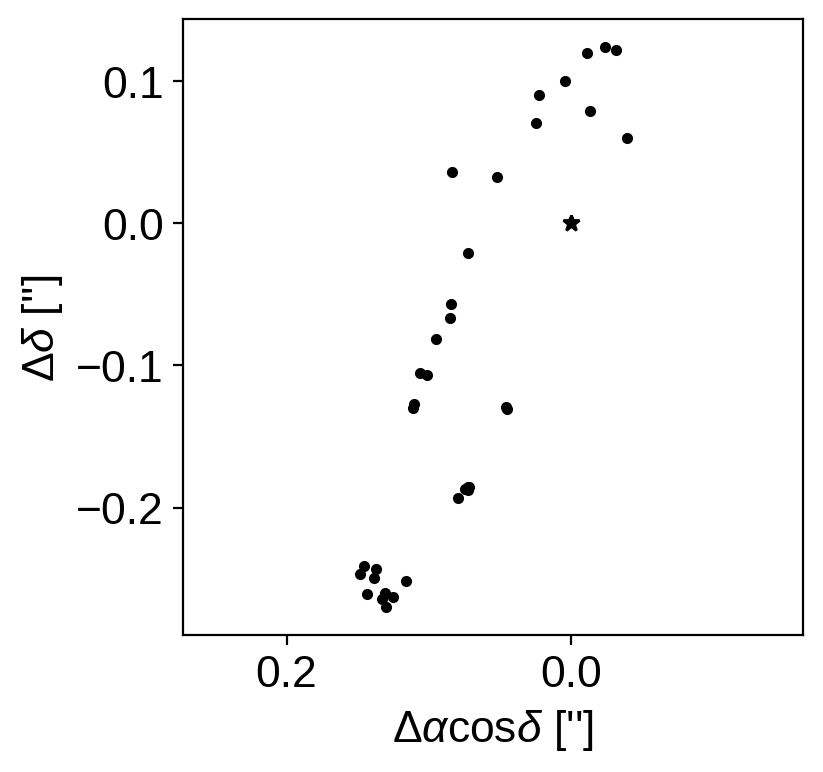

In [5]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

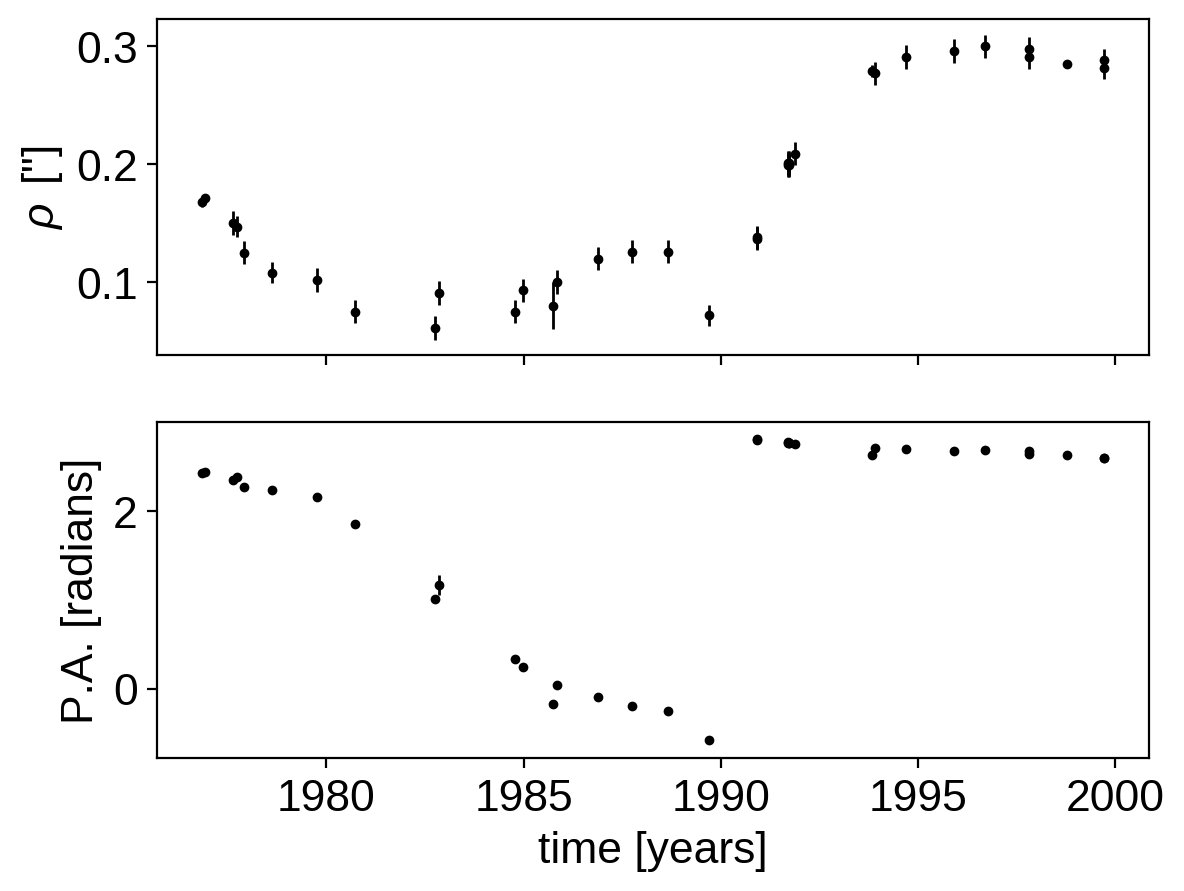

In [6]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [years]")

## Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

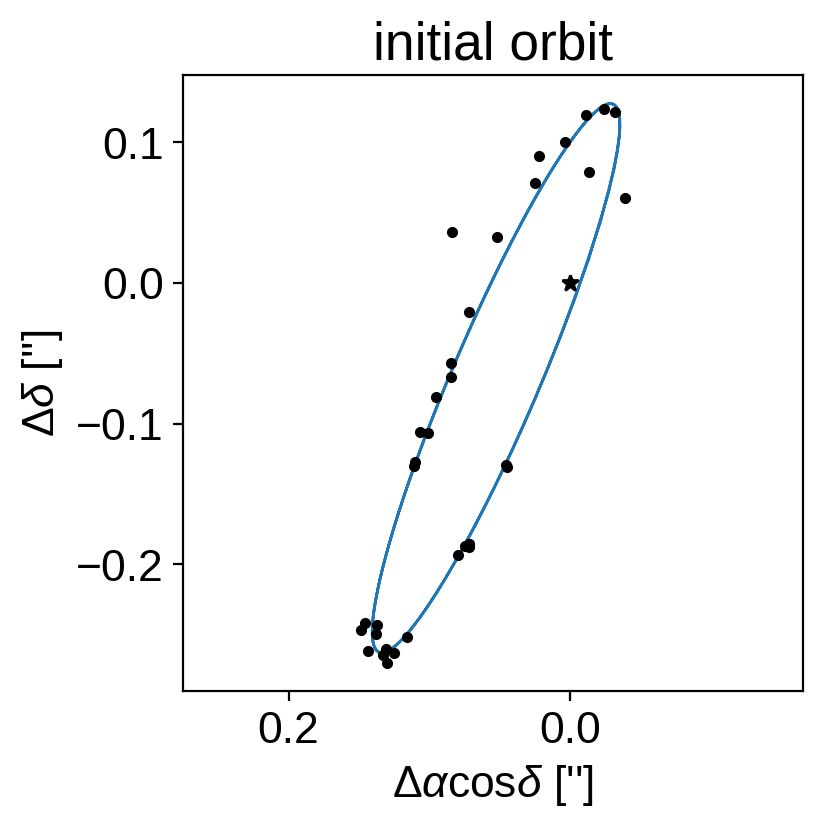

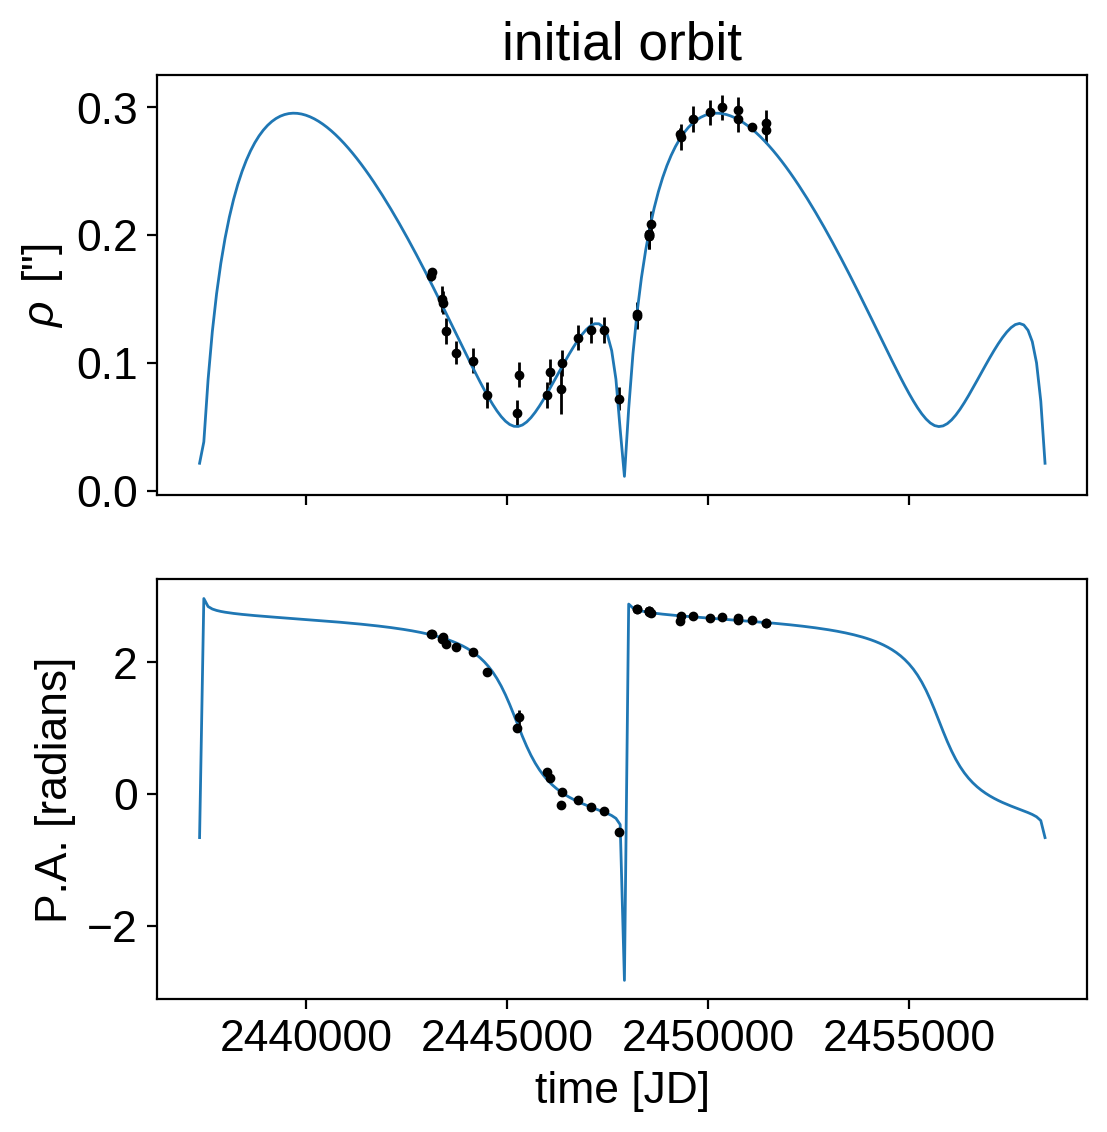

In [7]:
import pymc3 as pm
import theano
import theano.tensor as tt

import exoplanet as xo
from exoplanet.distributions import Angle

from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324  # arcsec
parallax = 1  # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg  # [rad]
omega = 251.6 * deg - np.pi  # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg
P = 28.8 * 365.25  # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value  # [Julian Date]

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega
)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t = np.linspace(T0 - P, T0 + P, num=200)  # days
rho, theta = theano.function([], orbit.get_relative_angles(t, parallax))()

# Plot the orbit
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit")

ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t, theta, color="C0", lw=1)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [JD]")

Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

In [8]:
yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)


def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)

        a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 25 years,
        # so we'll set a broad prior on logP
        logP = pm.Normal(
            "logP", mu=np.log(25 * yr), sd=10.0, testval=np.log(28.8 * yr)
        )
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        omega0 = 251.6 * deg - np.pi
        Omega0 = 159.6 * deg
        p = Angle("p", testval=0.5 * (Omega0 + omega0))
        m = Angle("m", testval=0.5 * (Omega0 - omega0))
        omega = pm.Deterministic("omega", p - m)
        Omega = pm.Deterministic("Omega", p + m)

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", T0 + P * phase / (2 * np.pi))

        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform(
            "cos_incl", lower=-1, upper=1, testval=np.cos(96.0 * deg)
        )
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.798)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun,
            t_periastron=tperi,
            period=P,
            incl=incl,
            ecc=ecc,
            omega=omega,
            Omega=Omega,
        )
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)

        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(astro_jds, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal(
            "log_rho_s", mu=np.log(np.median(rho_err)), sd=5.0
        )
        log_theta_s = pm.Normal(
            "log_theta_s", mu=np.log(np.median(theta_err)), sd=5.0
        )
        rho_tot_err = tt.sqrt(rho_err ** 2 + tt.exp(2 * log_rho_s))
        theta_tot_err = tt.sqrt(theta_err ** 2 + tt.exp(2 * log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(
            tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data)
        )
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = xo.optimize(map_soln, vars=[phase])
        map_soln = xo.optimize(map_soln, vars=[p, m, ecc])
        map_soln = xo.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = xo.optimize(map_soln)

    return model, map_soln


model, map_soln = get_model()

optimizing logp for variables: [log_theta_s, log_rho_s]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.048555e+02]

1it [00:00, 595.11it/s, logp=1.048555e+02]

2it [00:00, 691.22it/s, logp=1.448865e+02]

3it [00:00, 729.32it/s, logp=1.056457e+02]

4it [00:00, 827.16it/s, logp=1.457994e+02]

5it [00:00, 883.23it/s, logp=1.469999e+02]

6it [00:00, 875.58it/s, logp=1.471434e+02]

7it [00:00, 907.18it/s, logp=1.471440e+02]

8it [00:00, 921.02it/s, logp=1.471440e+02]

9it [00:00, 908.82it/s, logp=1.471440e+02]

10it [00:01,  9.61it/s, logp=1.471440e+02]


message: Optimization terminated successfully.
logp: 104.85554109304441 -> 147.14399186005338


optimizing logp for variables: [phase]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.471440e+02]

1it [00:00, 557.53it/s, logp=1.471440e+02]

2it [00:00, 689.91it/s, logp=-1.185831e+04]

3it [00:00, 757.69it/s, logp=1.471671e+02] 

4it [00:00, 707.51it/s, logp=1.472136e+02]

5it [00:00, 778.66it/s, logp=1.473986e+02]

6it [00:00, 830.66it/s, logp=1.481189e+02]

7it [00:00, 867.62it/s, logp=1.507231e+02]

8it [00:00, 845.92it/s, logp=1.565965e+02]

9it [00:00, 859.68it/s, logp=1.634911e+02]

10it [00:00, 882.45it/s, logp=1.666396e+02]

11it [00:00, 880.72it/s, logp=1.675455e+02]

12it [00:00, 892.31it/s, logp=1.676215e+02]

13it [00:00, 910.24it/s, logp=1.676248e+02]

14it [00:00, 905.35it/s, logp=1.676282e+02]

15it [00:00, 915.20it/s, logp=1.676337e+02]

16it [00:00, 926.32it/s, logp=1.676403e+02]

17it [00:00, 929.79it/s, logp=1.676419e+02]

18it [00:00, 929.74it/s, logp=1.676422e+02]

19it [00:00, 912.81it/s, logp=1.676422e+02]

20it [00:00, 912.08it/s, logp=1.676422e+02]

21it [00:00, 916.21it/s, logp=1.676422e+02]

22it [00:01, 21.43it/s, logp=1.676422e+02] 


message: Optimization terminated successfully.
logp: 147.14399186005338 -> 167.64220598197195


optimizing logp for variables: [ecc, m, p]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.676422e+02]

1it [00:00, 493.97it/s, logp=1.676422e+02]

2it [00:00, 604.54it/s, logp=-4.521021e+03]

3it [00:00, 693.92it/s, logp=1.682354e+02] 

4it [00:00, 676.01it/s, logp=1.667490e+02]

5it [00:00, 729.57it/s, logp=1.683674e+02]

6it [00:00, 748.54it/s, logp=1.686220e+02]

7it [00:00, 789.31it/s, logp=1.694033e+02]

8it [00:00, 802.18it/s, logp=1.714304e+02]

9it [00:00, 831.65it/s, logp=1.784310e+02]

10it [00:00, 773.41it/s, logp=1.921973e+02]

11it [00:00, 790.88it/s, logp=1.936845e+02]

12it [00:00, 804.25it/s, logp=1.964254e+02]

13it [00:00, 794.32it/s, logp=2.010939e+02]

14it [00:00, 795.02it/s, logp=2.074741e+02]

15it [00:00, 805.77it/s, logp=2.094264e+02]

16it [00:00, 811.45it/s, logp=2.098562e+02]

17it [00:00, 787.50it/s, logp=2.098999e+02]

18it [00:00, 792.17it/s, logp=2.099152e+02]

19it [00:00, 794.68it/s, logp=2.099416e+02]

20it [00:00, 800.55it/s, logp=2.099853e+02]

21it [00:00, 803.01it/s, logp=2.100398e+02]

22it [00:00, 806.66it/s, logp=2.100552e+02]

23it [00:00, 812.56it/s, logp=2.100609e+02]

24it [00:00, 811.32it/s, logp=2.100614e+02]

25it [00:00, 817.58it/s, logp=2.100617e+02]

26it [00:00, 817.22it/s, logp=2.100622e+02]

27it [00:00, 819.88it/s, logp=2.100629e+02]

28it [00:00, 817.23it/s, logp=2.100633e+02]

29it [00:00, 822.37it/s, logp=2.100634e+02]

30it [00:00, 821.71it/s, logp=2.100634e+02]

31it [00:00, 823.71it/s, logp=2.100634e+02]

32it [00:00, 828.22it/s, logp=2.100634e+02]

33it [00:00, 832.33it/s, logp=2.100634e+02]

34it [00:00, 42.11it/s, logp=2.100634e+02] 


message: Optimization terminated successfully.
logp: 167.64220598197198 -> 210.06340668297906


optimizing logp for variables: [phase, a_ang, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.100634e+02]

1it [00:00, 590.50it/s, logp=2.100634e+02]

2it [00:00, 693.16it/s, logp=-4.378171e+03]

3it [00:00, 657.24it/s, logp=2.102114e+02] 

4it [00:00, 671.28it/s, logp=2.103607e+02]

5it [00:00, 702.80it/s, logp=2.104883e+02]

6it [00:00, 728.68it/s, logp=2.105011e+02]

7it [00:00, 757.50it/s, logp=2.105011e+02]

8it [00:00, 790.04it/s, logp=2.105014e+02]

9it [00:00, 812.83it/s, logp=2.105014e+02]

10it [00:00, 832.30it/s, logp=2.105014e+02]

11it [00:00, 14.08it/s, logp=2.105014e+02] 


message: Optimization terminated successfully.
logp: 210.0634066829791 -> 210.5013698914921


optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.105014e+02]

1it [00:00, 445.49it/s, logp=2.105014e+02]

2it [00:00, 547.20it/s, logp=-4.041226e+03]

3it [00:00, 640.74it/s, logp=2.124628e+02] 

4it [00:00, 682.11it/s, logp=1.648448e+02]

5it [00:00, 725.58it/s, logp=2.125361e+02]

6it [00:00, 715.02it/s, logp=2.126469e+02]

7it [00:00, 714.36it/s, logp=2.128268e+02]

8it [00:00, 721.10it/s, logp=2.130889e+02]

9it [00:00, 734.18it/s, logp=2.132127e+02]

10it [00:00, 733.46it/s, logp=2.131910e+02]

11it [00:00, 753.94it/s, logp=2.132712e+02]

12it [00:00, 765.34it/s, logp=2.133790e+02]

13it [00:00, 759.14it/s, logp=2.135772e+02]

14it [00:00, 768.06it/s, logp=2.139432e+02]

15it [00:00, 775.68it/s, logp=2.145105e+02]

16it [00:00, 770.08it/s, logp=2.146599e+02]

17it [00:00, 775.87it/s, logp=2.148474e+02]

18it [00:00, 773.86it/s, logp=2.149170e+02]

19it [00:00, 774.22it/s, logp=2.149377e+02]

20it [00:00, 773.24it/s, logp=2.149628e+02]

21it [00:00, 777.75it/s, logp=2.149864e+02]

22it [00:00, 781.69it/s, logp=2.150041e+02]

23it [00:00, 776.14it/s, logp=2.150108e+02]

24it [00:00, 777.89it/s, logp=2.150182e+02]

25it [00:00, 781.77it/s, logp=2.150205e+02]

26it [00:00, 785.61it/s, logp=2.150210e+02]

27it [00:00, 784.09it/s, logp=2.150212e+02]

28it [00:00, 789.21it/s, logp=2.150212e+02]

29it [00:00, 791.13it/s, logp=2.150212e+02]

30it [00:00, 794.44it/s, logp=2.150212e+02]

31it [00:00, 791.93it/s, logp=2.150212e+02]

32it [00:00, 790.79it/s, logp=2.150212e+02]

33it [00:00, 785.23it/s, logp=2.150212e+02]

34it [00:00, 787.76it/s, logp=2.150212e+02]

35it [00:00, 785.76it/s, logp=2.150212e+02]

36it [00:00, 788.12it/s, logp=2.150212e+02]

37it [00:00, 794.55it/s, logp=2.150212e+02]

38it [00:00, 796.73it/s, logp=2.150212e+02]

39it [00:00, 801.46it/s, logp=2.150212e+02]

40it [00:00, 798.25it/s, logp=2.150212e+02]

41it [00:00, 802.79it/s, logp=2.150212e+02]

42it [00:00, 807.02it/s, logp=2.150212e+02]

43it [00:00, 811.81it/s, logp=2.150212e+02]

44it [00:00, 815.25it/s, logp=2.150212e+02]

45it [00:00, 819.06it/s, logp=2.150212e+02]

46it [00:00, 812.77it/s, logp=2.150212e+02]

47it [00:00, 816.17it/s, logp=2.150212e+02]

48it [00:00, 820.22it/s, logp=2.150212e+02]

49it [00:00, 823.89it/s, logp=2.150212e+02]

50it [00:00, 821.24it/s, logp=2.150212e+02]

51it [00:00, 825.05it/s, logp=2.150212e+02]

52it [00:00, 827.86it/s, logp=2.150212e+02]

53it [00:00, 831.23it/s, logp=2.150212e+02]

54it [00:00, 833.25it/s, logp=2.150212e+02]

55it [00:00, 835.41it/s, logp=2.150212e+02]

56it [00:00, 839.88it/s, logp=2.150212e+02]

57it [00:00, 841.79it/s, logp=2.150212e+02]

58it [00:00, 839.63it/s, logp=2.150212e+02]

59it [00:00, 835.78it/s, logp=2.150212e+02]

60it [00:00, 837.81it/s, logp=2.150212e+02]

61it [00:00, 840.16it/s, logp=2.150212e+02]

62it [00:00, 840.82it/s, logp=2.150212e+02]

63it [00:00, 843.72it/s, logp=2.150212e+02]

64it [00:00, 845.84it/s, logp=2.150212e+02]

65it [00:00, 847.99it/s, logp=2.150212e+02]

66it [00:00, 850.66it/s, logp=2.150212e+02]

67it [00:00, 851.86it/s, logp=2.150212e+02]

68it [00:00, 851.42it/s, logp=2.150212e+02]

69it [00:00, 852.56it/s, logp=2.150212e+02]

70it [00:00, 854.65it/s, logp=2.150212e+02]

71it [00:00, 856.55it/s, logp=2.150212e+02]

72it [00:00, 857.70it/s, logp=2.150212e+02]

73it [00:00, 859.78it/s, logp=2.150212e+02]

74it [00:00, 850.79it/s, logp=2.150212e+02]

75it [00:00, 851.90it/s, logp=2.150212e+02]

76it [00:00, 852.90it/s, logp=2.150212e+02]

77it [00:00, 853.94it/s, logp=2.150212e+02]

78it [00:00, 855.32it/s, logp=2.150212e+02]

79it [00:00, 857.31it/s, logp=2.150212e+02]

80it [00:00, 859.32it/s, logp=2.150212e+02]

81it [00:00, 860.58it/s, logp=2.150212e+02]

82it [00:00, 862.80it/s, logp=2.150212e+02]

83it [00:00, 858.30it/s, logp=2.150212e+02]

84it [00:00, 857.90it/s, logp=2.150212e+02]

85it [00:00, 859.60it/s, logp=2.150212e+02]

86it [00:00, 861.22it/s, logp=2.150212e+02]

87it [00:00, 867.57it/s, logp=2.150212e+02]

87it [00:00, 867.57it/s, logp=2.150212e+02]

88it [00:00, 867.57it/s, logp=2.150212e+02]

89it [00:00, 867.57it/s, logp=2.150212e+02]

90it [00:00, 867.57it/s, logp=2.150212e+02]

91it [00:00, 867.57it/s, logp=2.150212e+02]

92it [00:00, 867.57it/s, logp=2.150212e+02]

93it [00:00, 867.57it/s, logp=2.150212e+02]

94it [00:00, 867.57it/s, logp=2.150212e+02]

95it [00:00, 867.57it/s, logp=2.150212e+02]

96it [00:00, 867.57it/s, logp=2.150212e+02]

97it [00:00, 867.57it/s, logp=2.150212e+02]

98it [00:00, 867.57it/s, logp=2.150212e+02]

99it [00:00, 867.57it/s, logp=2.150212e+02]

100it [00:00, 867.57it/s, logp=2.150212e+02]

101it [00:00, 867.57it/s, logp=2.150212e+02]

102it [00:01, 87.75it/s, logp=2.150212e+02] 


message: Optimization terminated successfully.
logp: 210.5013698914921 -> 215.02117742211766


Now that we have a maximum a posteriori estimate of the parameters, let's take a look at the results to make sure that they seem reasonable.

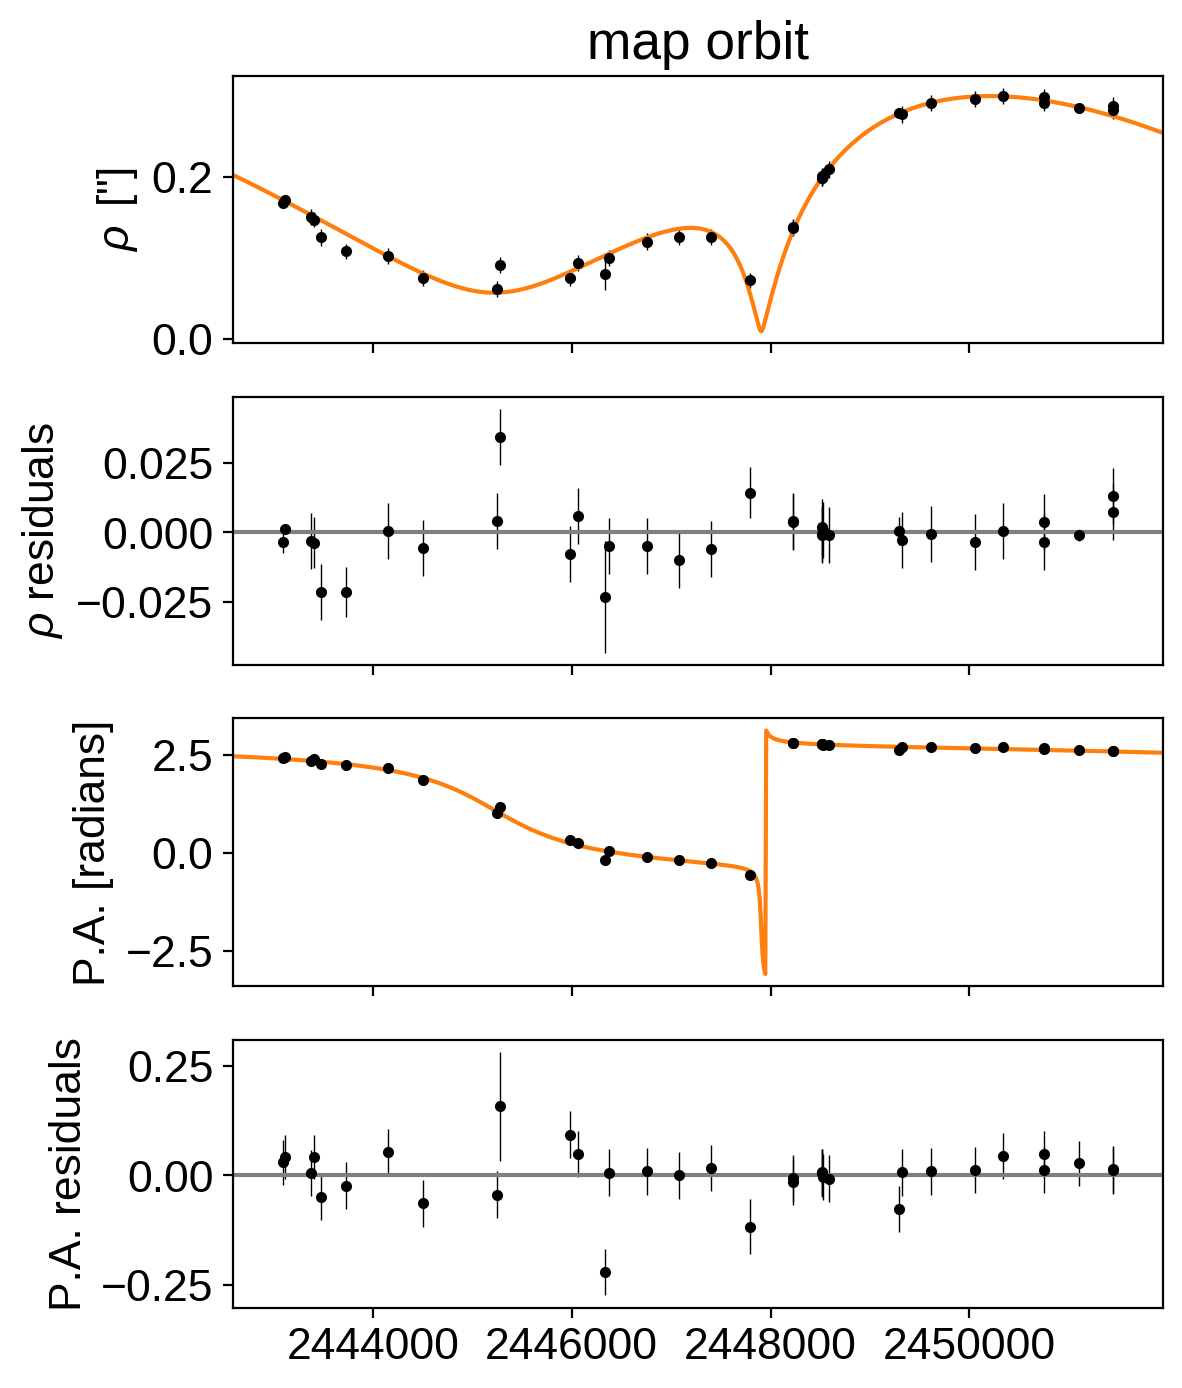

In [9]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err ** 2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    astro_jds, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw
)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    astro_jds, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

Now let's sample the posterior.

In [10]:
np.random.seed(1234)
with model:
    trace = pm.sample(
        tune=5000,
        draws=4000,
        start=map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9, adaptation_window=201),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]


Sampling 2 chains, 0 divergences:   0%|          | 0/18000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 7/18000 [00:00<04:42, 63.79draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 10/18000 [00:00<07:10, 41.75draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 13/18000 [00:00<10:32, 28.45draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 15/18000 [00:00<12:25, 24.11draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 17/18000 [00:00<13:52, 21.61draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 19/18000 [00:00<14:45, 20.29draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 22/18000 [00:00<13:45, 21.78draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 25/18000 [00:01<15:21, 19.50draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 27/18000 [00:01<15:53, 18.85draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 29/18000 [00:01<16:09, 18.53draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 32/18000 [00:01<15:32, 19.27draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 35/18000 [00:01<14:08, 21.17draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 38/18000 [00:01<14:13, 21.03draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 41/18000 [00:01<15:41, 19.08draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 44/18000 [00:01<14:14, 21.01draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 47/18000 [00:02<15:30, 19.29draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 50/18000 [00:02<15:15, 19.61draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 53/18000 [00:02<16:20, 18.29draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 55/18000 [00:02<16:31, 18.10draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 58/18000 [00:02<15:50, 18.88draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 61/18000 [00:02<14:57, 20.00draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 64/18000 [00:03<15:49, 18.89draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 66/18000 [00:03<16:09, 18.51draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 69/18000 [00:03<14:49, 20.16draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 72/18000 [00:03<15:06, 19.78draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 75/18000 [00:03<15:52, 18.81draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 77/18000 [00:03<16:18, 18.32draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 79/18000 [00:03<16:29, 18.11draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 81/18000 [00:03<16:34, 18.01draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 84/18000 [00:04<15:03, 19.83draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 87/18000 [00:04<14:01, 21.28draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 90/18000 [00:04<14:05, 21.18draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 93/18000 [00:04<14:01, 21.28draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 96/18000 [00:04<15:31, 19.21draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 98/18000 [00:04<15:48, 18.86draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 100/18000 [00:04<16:00, 18.64draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 102/18000 [00:05<16:03, 18.57draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 104/18000 [00:05<16:07, 18.49draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 108/18000 [00:05<14:45, 20.20draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 111/18000 [00:05<14:11, 21.01draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 114/18000 [00:05<13:19, 22.36draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 117/18000 [00:05<12:53, 23.11draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 120/18000 [00:05<13:58, 21.33draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 123/18000 [00:05<14:36, 20.40draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 126/18000 [00:06<15:22, 19.38draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 129/18000 [00:06<15:26, 19.28draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 132/18000 [00:06<14:09, 21.04draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 135/18000 [00:06<13:11, 22.58draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 138/18000 [00:06<12:30, 23.81draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 141/18000 [00:06<13:49, 21.53draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 145/18000 [00:06<12:08, 24.50draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 148/18000 [00:07<11:50, 25.13draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 151/18000 [00:07<12:03, 24.68draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 154/18000 [00:07<13:16, 22.40draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 157/18000 [00:07<12:52, 23.10draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 160/18000 [00:07<12:24, 23.96draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 163/18000 [00:07<11:55, 24.92draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 166/18000 [00:07<11:40, 25.46draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 171/18000 [00:07<10:50, 27.40draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 175/18000 [00:08<10:08, 29.27draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 179/18000 [00:08<09:50, 30.16draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 183/18000 [00:08<10:19, 28.74draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 187/18000 [00:08<09:39, 30.76draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 191/18000 [00:08<09:53, 29.99draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 195/18000 [00:08<10:45, 27.58draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 199/18000 [00:08<11:20, 26.17draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 202/18000 [00:09<11:47, 25.17draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 205/18000 [00:09<14:16, 20.78draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 208/18000 [00:09<14:00, 21.16draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 211/18000 [00:09<13:12, 22.43draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 214/18000 [00:09<13:10, 22.51draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 217/18000 [00:09<13:39, 21.69draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 220/18000 [00:09<13:43, 21.58draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 223/18000 [00:10<12:58, 22.84draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 227/18000 [00:10<12:19, 24.04draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 230/18000 [00:10<11:52, 24.92draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 233/18000 [00:10<11:31, 25.69draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 236/18000 [00:10<12:49, 23.10draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 240/18000 [00:10<11:56, 24.77draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 243/18000 [00:10<12:52, 22.98draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 246/18000 [00:10<13:28, 21.95draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 249/18000 [00:11<14:14, 20.77draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 253/18000 [00:11<13:19, 22.20draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 258/18000 [00:11<11:59, 24.64draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 261/18000 [00:11<11:47, 25.07draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 265/18000 [00:11<11:15, 26.24draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 270/18000 [00:11<10:21, 28.51draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 273/18000 [00:11<11:10, 26.43draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 277/18000 [00:12<10:15, 28.82draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 281/18000 [00:12<10:06, 29.21draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 285/18000 [00:12<11:54, 24.80draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 288/18000 [00:12<13:48, 21.38draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 291/18000 [00:12<13:00, 22.69draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 294/18000 [00:12<13:05, 22.55draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 298/18000 [00:13<11:51, 24.88draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 302/18000 [00:13<10:42, 27.52draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 305/18000 [00:13<12:20, 23.91draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 308/18000 [00:13<12:23, 23.79draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 311/18000 [00:13<13:07, 22.47draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 314/18000 [00:13<13:57, 21.12draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 318/18000 [00:13<12:19, 23.90draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 322/18000 [00:14<12:25, 23.71draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 327/18000 [00:14<10:55, 26.98draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 330/18000 [00:14<11:51, 24.82draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 333/18000 [00:14<11:36, 25.35draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 339/18000 [00:14<10:10, 28.94draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 343/18000 [00:14<10:08, 29.01draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 347/18000 [00:14<10:09, 28.95draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 351/18000 [00:14<09:21, 31.44draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 355/18000 [00:15<11:25, 25.76draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 358/18000 [00:15<11:27, 25.65draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 361/18000 [00:15<11:21, 25.89draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 364/18000 [00:15<12:42, 23.12draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 367/18000 [00:15<13:45, 21.36draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 370/18000 [00:15<13:19, 22.04draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 374/18000 [00:15<12:37, 23.26draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 377/18000 [00:16<13:00, 22.59draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 381/18000 [00:16<12:00, 24.44draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 384/18000 [00:16<11:39, 25.18draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 389/18000 [00:16<10:07, 28.99draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 396/18000 [00:16<08:29, 34.52draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 411/18000 [00:16<06:34, 44.61draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 426/18000 [00:16<05:11, 56.42draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 440/18000 [00:16<04:19, 67.77draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 452/18000 [00:16<03:46, 77.41draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 467/18000 [00:17<03:14, 89.94draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 481/18000 [00:17<02:54, 100.36draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 494/18000 [00:17<02:45, 105.93draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 507/18000 [00:17<02:37, 110.73draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 520/18000 [00:17<02:38, 110.16draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 533/18000 [00:17<02:32, 114.28draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 548/18000 [00:17<02:22, 122.26draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 561/18000 [00:17<02:28, 117.80draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 577/18000 [00:17<02:17, 127.12draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 592/18000 [00:18<02:12, 131.75draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 606/18000 [00:18<02:15, 128.07draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 622/18000 [00:18<02:09, 133.78draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 636/18000 [00:18<02:18, 125.16draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 651/18000 [00:18<02:12, 130.69draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 666/18000 [00:18<02:08, 134.86draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 680/18000 [00:18<02:15, 128.27draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 694/18000 [00:18<02:27, 117.09draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 707/18000 [00:18<02:25, 118.99draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 723/18000 [00:19<02:14, 128.16draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 740/18000 [00:19<02:06, 135.97draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 754/18000 [00:19<02:11, 130.93draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 768/18000 [00:19<02:11, 130.73draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 784/18000 [00:19<02:04, 138.04draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 804/18000 [00:19<01:53, 151.67draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 825/18000 [00:19<01:45, 163.47draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 845/18000 [00:19<01:39, 172.58draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 863/18000 [00:19<01:42, 167.87draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 883/18000 [00:20<01:37, 175.22draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 901/18000 [00:20<01:41, 169.28draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 927/18000 [00:20<01:30, 188.89draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 951/18000 [00:20<01:24, 201.25draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 973/18000 [00:20<01:26, 196.52draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 997/18000 [00:20<01:22, 206.17draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1022/18000 [00:20<01:18, 216.39draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1045/18000 [00:20<01:17, 218.83draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1068/18000 [00:20<01:18, 215.05draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1091/18000 [00:21<01:18, 216.41draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1113/18000 [00:21<01:23, 201.85draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1134/18000 [00:21<01:26, 194.98draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1155/18000 [00:21<01:24, 198.50draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1176/18000 [00:21<01:23, 200.34draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1197/18000 [00:21<01:24, 200.03draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1219/18000 [00:21<01:22, 203.35draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1241/18000 [00:21<01:21, 206.20draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1262/18000 [00:21<01:23, 201.18draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1283/18000 [00:21<01:27, 192.00draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1305/18000 [00:22<01:23, 198.96draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1328/18000 [00:22<01:21, 205.42draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1349/18000 [00:22<01:27, 190.97draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1369/18000 [00:22<01:27, 189.77draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1389/18000 [00:22<01:26, 191.40draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1409/18000 [00:22<01:31, 180.78draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1432/18000 [00:22<01:26, 192.18draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1456/18000 [00:22<01:20, 204.35draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1477/18000 [00:22<01:21, 202.12draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1498/18000 [00:23<01:27, 188.10draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1521/18000 [00:23<01:23, 196.90draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1542/18000 [00:23<01:23, 197.87draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1563/18000 [00:23<01:29, 183.21draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1582/18000 [00:23<01:29, 184.46draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1605/18000 [00:23<01:23, 195.79draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1627/18000 [00:23<01:22, 199.32draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1650/18000 [00:23<01:20, 204.23draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1671/18000 [00:23<01:26, 188.24draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1693/18000 [00:24<01:23, 194.92draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1713/18000 [00:24<01:27, 185.42draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1732/18000 [00:24<01:38, 165.57draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1751/18000 [00:24<01:34, 171.18draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1769/18000 [00:24<01:37, 166.30draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1789/18000 [00:24<01:33, 173.17draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1810/18000 [00:24<01:28, 182.37draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1829/18000 [00:24<01:38, 163.68draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1848/18000 [00:25<01:35, 168.81draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1872/18000 [00:25<01:27, 184.59draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1892/18000 [00:25<01:26, 185.91draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1912/18000 [00:25<01:30, 177.43draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1931/18000 [00:25<01:29, 179.42draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1950/18000 [00:25<01:31, 174.74draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1970/18000 [00:25<01:28, 181.38draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1989/18000 [00:25<01:30, 177.68draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 2010/18000 [00:25<01:26, 185.26draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2029/18000 [00:26<01:32, 173.58draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2050/18000 [00:26<01:28, 181.13draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2069/18000 [00:26<01:26, 183.58draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2090/18000 [00:26<01:23, 189.79draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2110/18000 [00:26<01:22, 191.96draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2133/18000 [00:26<01:19, 199.42draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2154/18000 [00:26<01:22, 193.04draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2174/18000 [00:26<01:24, 187.33draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2193/18000 [00:26<01:25, 184.91draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2212/18000 [00:26<01:24, 185.82draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2231/18000 [00:27<01:28, 179.01draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2254/18000 [00:27<01:23, 188.38draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2274/18000 [00:27<01:23, 188.14draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2297/18000 [00:27<01:19, 196.63draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2317/18000 [00:27<01:26, 180.65draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2336/18000 [00:27<01:27, 178.20draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2355/18000 [00:27<01:31, 171.58draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2374/18000 [00:27<01:28, 176.12draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2398/18000 [00:27<01:22, 189.11draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2418/18000 [00:28<01:28, 176.64draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2438/18000 [00:28<01:25, 182.06draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2457/18000 [00:28<01:28, 176.25draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2475/18000 [00:28<01:29, 174.06draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2495/18000 [00:28<01:28, 175.89draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2514/18000 [00:28<01:26, 179.35draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2533/18000 [00:28<01:25, 180.55draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2552/18000 [00:28<01:24, 181.93draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2573/18000 [00:28<01:21, 188.19draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2594/18000 [00:29<01:20, 190.98draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2614/18000 [00:29<01:20, 192.26draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2638/18000 [00:29<01:15, 204.03draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2662/18000 [00:29<01:12, 212.35draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2684/18000 [00:29<01:20, 191.14draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2704/18000 [00:29<01:21, 186.95draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2724/18000 [00:29<01:24, 181.15draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2743/18000 [00:29<01:27, 175.00draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2761/18000 [00:29<01:29, 170.25draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2779/18000 [00:30<01:39, 152.28draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2795/18000 [00:30<01:42, 148.54draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2812/18000 [00:30<01:38, 154.08draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2832/18000 [00:30<01:32, 164.17draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2850/18000 [00:30<01:30, 167.27draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2869/18000 [00:30<01:28, 170.82draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2889/18000 [00:30<01:25, 175.91draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2908/18000 [00:30<01:24, 178.09draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2927/18000 [00:30<01:23, 181.07draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2946/18000 [00:31<01:22, 181.52draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2965/18000 [00:31<01:22, 183.10draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2984/18000 [00:31<01:22, 180.95draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3004/18000 [00:31<01:20, 185.23draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3026/18000 [00:31<01:17, 194.24draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3051/18000 [00:31<01:12, 206.99draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3073/18000 [00:31<01:15, 197.08draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3094/18000 [00:31<01:23, 178.86draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3113/18000 [00:31<01:29, 167.27draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3131/18000 [00:32<01:32, 160.12draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3151/18000 [00:32<01:27, 168.85draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3172/18000 [00:32<01:23, 177.33draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3193/18000 [00:32<01:19, 185.37draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3212/18000 [00:32<01:21, 180.92draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3231/18000 [00:32<01:24, 175.28draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3250/18000 [00:32<01:23, 177.62draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3271/18000 [00:32<01:20, 183.46draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3292/18000 [00:32<01:18, 187.95draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3313/18000 [00:33<01:15, 193.92draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 3333/18000 [00:33<01:17, 188.20draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 3357/18000 [00:33<01:13, 200.45draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3381/18000 [00:33<01:09, 210.72draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3403/18000 [00:33<01:11, 204.21draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3424/18000 [00:33<01:17, 187.43draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3444/18000 [00:33<01:19, 182.76draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3465/18000 [00:33<01:16, 189.84draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3485/18000 [00:33<01:19, 183.23draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3504/18000 [00:34<01:18, 184.71draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3527/18000 [00:34<01:13, 196.12draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3547/18000 [00:34<01:13, 196.32draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3568/18000 [00:34<01:12, 199.44draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3591/18000 [00:34<01:09, 206.94draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3612/18000 [00:34<01:10, 202.73draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3633/18000 [00:34<01:13, 196.72draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3655/18000 [00:34<01:10, 202.34draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3676/18000 [00:34<01:13, 194.25draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3696/18000 [00:34<01:15, 189.40draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3716/18000 [00:35<01:14, 191.57draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3736/18000 [00:35<01:20, 177.76draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3755/18000 [00:35<01:22, 173.63draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3773/18000 [00:35<01:24, 167.72draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3790/18000 [00:35<01:26, 163.55draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3807/18000 [00:35<01:33, 152.08draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3826/18000 [00:35<01:28, 160.26draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3846/18000 [00:35<01:23, 169.84draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3864/18000 [00:36<01:25, 165.99draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3882/18000 [00:36<01:23, 169.79draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3900/18000 [00:36<01:22, 170.10draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3918/18000 [00:36<01:21, 171.97draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3936/18000 [00:36<01:25, 165.45draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3955/18000 [00:36<01:22, 169.59draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3976/18000 [00:36<01:18, 179.36draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3995/18000 [00:36<01:19, 176.25draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4019/18000 [00:36<01:13, 191.08draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4042/18000 [00:36<01:09, 200.40draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4067/18000 [00:37<01:06, 210.59draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4089/18000 [00:37<01:06, 208.30draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4111/18000 [00:37<01:05, 211.21draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4133/18000 [00:37<01:07, 205.63draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4154/18000 [00:37<01:14, 185.89draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4174/18000 [00:37<01:17, 177.40draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4193/18000 [00:37<01:20, 172.32draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4211/18000 [00:37<01:21, 168.98draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4230/18000 [00:37<01:18, 174.37draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4254/18000 [00:38<01:12, 188.37draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4274/18000 [00:38<01:12, 189.33draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4294/18000 [00:38<01:11, 192.22draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4314/18000 [00:38<01:11, 190.39draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4334/18000 [00:38<01:21, 168.45draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4355/18000 [00:38<01:16, 179.06draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4376/18000 [00:38<01:13, 185.42draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4400/18000 [00:38<01:08, 197.53draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4421/18000 [00:38<01:11, 191.17draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4441/18000 [00:39<01:12, 187.49draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4461/18000 [00:39<01:22, 164.79draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4479/18000 [00:39<01:21, 166.67draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4498/18000 [00:39<01:18, 171.60draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4521/18000 [00:39<01:12, 185.00draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4543/18000 [00:39<01:09, 193.15draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4565/18000 [00:39<01:07, 199.51draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4586/18000 [00:39<01:08, 195.80draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4607/18000 [00:39<01:07, 198.67draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4628/18000 [00:40<01:10, 190.45draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4648/18000 [00:40<01:13, 181.56draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4667/18000 [00:40<01:12, 183.94draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4690/18000 [00:40<01:08, 194.37draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4715/18000 [00:40<01:04, 205.62draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4736/18000 [00:40<01:06, 198.68draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4757/18000 [00:40<01:08, 193.51draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4778/18000 [00:40<01:08, 193.95draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4798/18000 [00:40<01:12, 180.97draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4817/18000 [00:41<01:15, 175.23draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4835/18000 [00:41<01:17, 169.06draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4854/18000 [00:41<01:15, 174.44draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4873/18000 [00:41<01:14, 176.58draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4895/18000 [00:41<01:10, 186.01draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4919/18000 [00:41<01:06, 197.78draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4940/18000 [00:41<01:05, 199.80draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4961/18000 [00:41<01:07, 192.55draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4982/18000 [00:41<01:06, 197.03draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5002/18000 [00:42<01:09, 188.12draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5022/18000 [00:42<01:10, 184.83draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5044/18000 [00:42<01:07, 191.09draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5064/18000 [00:42<01:08, 188.72draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5083/18000 [00:42<01:12, 178.91draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5102/18000 [00:42<01:13, 174.53draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5120/18000 [00:42<01:15, 170.23draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 5138/18000 [00:42<01:15, 171.25draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 5157/18000 [00:42<01:12, 176.15draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5177/18000 [00:43<01:11, 180.31draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5197/18000 [00:43<01:09, 183.75draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5216/18000 [00:43<01:14, 171.21draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5234/18000 [00:43<01:20, 159.05draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5251/18000 [00:43<01:24, 151.62draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5268/18000 [00:43<01:22, 153.90draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5284/18000 [00:43<01:24, 150.07draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5301/18000 [00:43<01:21, 155.19draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5320/18000 [00:43<01:17, 163.89draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5337/18000 [00:44<01:19, 158.75draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5357/18000 [00:44<01:15, 167.58draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5377/18000 [00:44<01:12, 174.24draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5395/18000 [00:44<01:14, 168.90draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5414/18000 [00:44<01:12, 173.26draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5436/18000 [00:44<01:07, 184.81draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5459/18000 [00:44<01:04, 195.55draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5479/18000 [00:44<01:06, 186.90draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5499/18000 [00:44<01:16, 163.49draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5517/18000 [00:45<01:16, 162.15draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5534/18000 [00:45<01:20, 155.71draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5551/18000 [00:45<01:22, 151.67draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5572/18000 [00:45<01:16, 163.42draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5590/18000 [00:45<01:14, 166.49draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5608/18000 [00:45<01:16, 162.65draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5627/18000 [00:45<01:13, 168.91draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5645/18000 [00:45<01:17, 159.45draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5662/18000 [00:45<01:16, 162.28draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5679/18000 [00:46<01:17, 159.95draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5697/18000 [00:46<01:16, 161.10draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5715/18000 [00:46<01:14, 164.83draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5733/18000 [00:46<01:13, 167.49draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5751/18000 [00:46<01:11, 170.56draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5772/18000 [00:46<01:08, 178.82draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5791/18000 [00:46<01:10, 172.99draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5809/18000 [00:46<01:13, 165.31draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5827/18000 [00:46<01:12, 167.36draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5848/18000 [00:47<01:09, 175.51draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5866/18000 [00:47<01:09, 174.04draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5889/18000 [00:47<01:04, 187.55draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5912/18000 [00:47<01:01, 197.64draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5933/18000 [00:47<01:01, 197.35draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5954/18000 [00:47<01:08, 174.70draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5973/18000 [00:47<01:14, 162.06draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5990/18000 [00:47<01:13, 162.71draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 6007/18000 [00:47<01:16, 155.89draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 6026/18000 [00:48<01:14, 160.89draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6050/18000 [00:48<01:07, 176.87draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6074/18000 [00:48<01:02, 190.61draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6094/18000 [00:48<01:04, 185.27draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6114/18000 [00:48<01:03, 186.27draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6137/18000 [00:48<01:00, 197.28draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6159/18000 [00:48<00:59, 197.60draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6180/18000 [00:48<01:03, 185.50draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6199/18000 [00:48<01:05, 180.03draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6220/18000 [00:49<01:03, 186.03draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6239/18000 [00:49<01:04, 181.80draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6258/18000 [00:49<01:04, 182.45draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6277/18000 [00:49<01:05, 178.77draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6295/18000 [00:49<01:10, 165.64draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6312/18000 [00:49<01:10, 166.48draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6329/18000 [00:49<01:09, 166.76draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6348/18000 [00:49<01:08, 170.82draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6368/18000 [00:49<01:06, 174.84draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6389/18000 [00:50<01:03, 181.62draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6408/18000 [00:50<01:05, 177.03draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6428/18000 [00:50<01:03, 182.91draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6447/18000 [00:50<01:03, 181.95draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6467/18000 [00:50<01:02, 185.61draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6486/18000 [00:50<01:03, 180.94draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6505/18000 [00:50<01:04, 178.21draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6524/18000 [00:50<01:04, 179.28draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6545/18000 [00:50<01:01, 187.02draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6564/18000 [00:51<01:03, 180.82draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6583/18000 [00:51<01:06, 171.52draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6601/18000 [00:51<01:11, 160.33draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6618/18000 [00:51<01:11, 159.48draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6635/18000 [00:51<01:12, 156.15draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6652/18000 [00:51<01:11, 159.64draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6669/18000 [00:51<01:12, 156.40draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6685/18000 [00:51<01:16, 148.30draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6700/18000 [00:51<01:19, 141.73draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6715/18000 [00:52<01:19, 142.78draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6734/18000 [00:52<01:13, 152.94draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6754/18000 [00:52<01:09, 162.95draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6771/18000 [00:52<01:10, 160.18draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6788/18000 [00:52<01:11, 156.89draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6806/18000 [00:52<01:09, 161.28draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6827/18000 [00:52<01:04, 173.27draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6851/18000 [00:52<00:58, 188.98draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6871/18000 [00:52<00:58, 190.66draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6891/18000 [00:53<00:59, 186.00draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6910/18000 [00:53<00:59, 184.93draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6929/18000 [00:53<00:59, 185.62draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6950/18000 [00:53<00:58, 190.01draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6970/18000 [00:53<00:57, 191.80draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6990/18000 [00:53<00:57, 190.71draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7011/18000 [00:53<00:56, 193.65draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7036/18000 [00:53<00:53, 206.73draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7057/18000 [00:53<00:54, 200.03draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7078/18000 [00:53<01:01, 178.59draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7097/18000 [00:54<01:02, 173.07draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7115/18000 [00:54<01:03, 171.17draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7133/18000 [00:54<01:04, 168.89draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7151/18000 [00:54<01:03, 170.56draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7169/18000 [00:54<01:07, 160.81draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7189/18000 [00:54<01:04, 167.42draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7206/18000 [00:54<01:06, 161.59draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7223/18000 [00:54<01:10, 153.63draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7239/18000 [00:55<01:12, 149.40draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7255/18000 [00:55<01:12, 148.14draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7274/18000 [00:55<01:08, 155.47draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7293/18000 [00:55<01:05, 163.63draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7311/18000 [00:55<01:03, 168.19draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7329/18000 [00:55<01:05, 163.55draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7349/18000 [00:55<01:02, 170.17draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7369/18000 [00:55<01:00, 175.25draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7387/18000 [00:55<01:00, 175.30draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7406/18000 [00:55<00:59, 177.50draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7425/18000 [00:56<00:59, 178.61draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7443/18000 [00:56<01:00, 174.22draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7463/18000 [00:56<00:58, 179.83draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7483/18000 [00:56<00:57, 182.86draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7505/18000 [00:56<00:54, 190.86draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7526/18000 [00:56<00:54, 193.63draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7546/18000 [00:56<00:53, 195.13draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7566/18000 [00:56<00:53, 195.43draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7586/18000 [00:56<00:57, 181.04draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7605/18000 [00:57<01:01, 169.31draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7623/18000 [00:57<01:03, 163.97draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7643/18000 [00:57<01:00, 172.32draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7663/18000 [00:57<00:57, 179.53draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7682/18000 [00:57<00:56, 181.58draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7701/18000 [00:57<00:57, 179.62draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7721/18000 [00:57<00:56, 182.01draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7743/18000 [00:57<00:53, 190.37draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7764/18000 [00:57<00:52, 194.49draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7784/18000 [00:58<00:53, 189.91draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7804/18000 [00:58<00:52, 192.46draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7824/18000 [00:58<00:52, 193.39draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7846/18000 [00:58<00:51, 199.03draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7866/18000 [00:58<00:51, 198.26draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7886/18000 [00:58<00:51, 195.06draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7908/18000 [00:58<00:50, 199.67draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7929/18000 [00:58<00:53, 186.52draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7948/18000 [00:58<00:59, 168.79draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7966/18000 [00:59<01:00, 166.34draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7983/18000 [00:59<01:01, 162.35draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 8002/18000 [00:59<00:59, 167.27draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8020/18000 [00:59<00:59, 168.62draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8038/18000 [00:59<01:01, 161.56draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8055/18000 [00:59<01:00, 163.55draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8072/18000 [00:59<01:00, 163.46draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8091/18000 [00:59<00:59, 167.19draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8115/18000 [00:59<00:54, 182.78draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8134/18000 [00:59<00:54, 181.85draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8153/18000 [01:00<00:58, 169.26draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8171/18000 [01:00<01:00, 163.41draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8188/18000 [01:00<01:02, 156.71draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8204/18000 [01:00<01:04, 151.60draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8220/18000 [01:00<01:05, 150.09draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8236/18000 [01:00<01:07, 143.61draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8252/18000 [01:00<01:06, 147.36draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8272/18000 [01:00<01:00, 159.50draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8293/18000 [01:00<00:56, 171.80draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8315/18000 [01:01<00:52, 183.88draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8335/18000 [01:01<00:54, 178.90draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8354/18000 [01:01<00:53, 180.09draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8373/18000 [01:01<00:52, 182.82draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8396/18000 [01:01<00:49, 193.71draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8417/18000 [01:01<00:48, 198.15draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8438/18000 [01:01<00:51, 185.39draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8457/18000 [01:01<00:51, 184.58draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8477/18000 [01:01<00:50, 188.16draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8497/18000 [01:02<00:52, 181.29draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8518/18000 [01:02<00:50, 188.76draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8539/18000 [01:02<00:48, 193.33draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8559/18000 [01:02<00:48, 194.54draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8580/18000 [01:02<00:47, 197.99draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8601/18000 [01:02<00:46, 201.21draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8622/18000 [01:02<00:49, 189.06draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8642/18000 [01:02<00:50, 184.95draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8661/18000 [01:02<00:52, 176.64draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8680/18000 [01:03<00:52, 178.57draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8699/18000 [01:03<00:51, 180.73draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8718/18000 [01:03<00:50, 183.17draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8737/18000 [01:03<00:51, 180.73draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8756/18000 [01:03<00:50, 182.92draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8775/18000 [01:03<00:51, 179.80draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8794/18000 [01:03<00:51, 178.00draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8812/18000 [01:03<00:54, 169.06draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8830/18000 [01:03<00:55, 166.56draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8848/18000 [01:04<00:54, 168.85draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8867/18000 [01:04<00:52, 173.53draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8887/18000 [01:04<00:50, 179.91draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8907/18000 [01:04<00:49, 183.31draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8926/18000 [01:04<00:50, 180.72draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8945/18000 [01:04<00:49, 182.37draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8964/18000 [01:04<00:49, 181.59draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8983/18000 [01:04<00:52, 171.88draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9001/18000 [01:04<00:55, 162.89draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9019/18000 [01:04<00:54, 165.77draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9036/18000 [01:05<00:54, 163.44draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9055/18000 [01:05<00:53, 167.34draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9074/18000 [01:05<00:51, 173.16draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9092/18000 [01:05<00:53, 165.98draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9112/18000 [01:05<00:51, 172.99draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9130/18000 [01:05<00:52, 169.26draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9148/18000 [01:05<00:51, 172.15draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9167/18000 [01:05<00:50, 173.26draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9188/18000 [01:05<00:48, 181.27draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9211/18000 [01:06<00:45, 193.54draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9231/18000 [01:06<00:45, 192.93draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9251/18000 [01:06<00:50, 172.64draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9269/18000 [01:06<00:54, 161.06draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9287/18000 [01:06<00:52, 164.76draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9308/18000 [01:06<00:49, 174.56draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9328/18000 [01:06<00:48, 179.52draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9347/18000 [01:06<00:48, 178.71draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9366/18000 [01:06<00:50, 170.01draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9386/18000 [01:07<00:48, 176.63draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9405/18000 [01:07<00:48, 178.16draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9424/18000 [01:07<00:47, 179.52draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9445/18000 [01:07<00:47, 181.53draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9464/18000 [01:07<00:46, 183.26draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9483/18000 [01:07<00:46, 184.40draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9502/18000 [01:07<00:46, 180.94draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9521/18000 [01:07<00:46, 181.98draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9540/18000 [01:07<00:47, 177.88draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9558/18000 [01:08<00:48, 173.09draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9578/18000 [01:08<00:46, 179.47draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9599/18000 [01:08<00:45, 186.29draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9621/18000 [01:08<00:43, 193.32draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9641/18000 [01:08<00:47, 177.22draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9660/18000 [01:08<00:51, 160.83draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9677/18000 [01:08<00:51, 162.97draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9695/18000 [01:08<00:49, 166.79draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9716/18000 [01:08<00:47, 174.31draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9736/18000 [01:09<00:45, 179.93draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9761/18000 [01:09<00:42, 194.55draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9784/18000 [01:09<00:40, 203.37draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9805/18000 [01:09<00:41, 199.74draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9826/18000 [01:09<00:43, 188.90draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9846/18000 [01:09<00:46, 175.43draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9864/18000 [01:09<00:47, 171.10draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9882/18000 [01:09<00:49, 164.47draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9900/18000 [01:09<00:48, 167.79draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9921/18000 [01:10<00:45, 177.56draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9940/18000 [01:10<00:44, 179.89draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9959/18000 [01:10<00:45, 175.28draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9977/18000 [01:10<00:45, 176.25draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 9998/18000 [01:10<00:43, 185.04draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10019/18000 [01:10<00:41, 191.07draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10039/18000 [01:10<00:43, 182.55draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10058/18000 [01:10<00:43, 183.52draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10077/18000 [01:10<00:44, 177.73draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10097/18000 [01:11<00:43, 180.83draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10117/18000 [01:11<00:42, 185.18draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10137/18000 [01:11<00:41, 188.08draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10156/18000 [01:11<00:42, 186.18draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10175/18000 [01:11<00:42, 182.43draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10194/18000 [01:11<00:43, 178.33draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10213/18000 [01:11<00:43, 177.98draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10232/18000 [01:11<00:43, 177.97draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10251/18000 [01:11<00:43, 180.04draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10270/18000 [01:11<00:43, 179.74draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10288/18000 [01:12<00:43, 175.44draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10310/18000 [01:12<00:42, 180.48draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10329/18000 [01:12<00:42, 180.55draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10348/18000 [01:12<00:42, 181.06draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10367/18000 [01:12<00:41, 181.98draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10387/18000 [01:12<00:41, 185.26draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10409/18000 [01:12<00:39, 192.26draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10430/18000 [01:12<00:38, 196.60draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10450/18000 [01:12<00:38, 197.32draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10470/18000 [01:13<00:38, 195.79draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10491/18000 [01:13<00:38, 195.46draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10512/18000 [01:13<00:37, 198.49draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10532/18000 [01:13<00:39, 189.51draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10552/18000 [01:13<00:40, 185.69draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10572/18000 [01:13<00:39, 187.79draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10591/18000 [01:13<00:41, 178.95draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10611/18000 [01:13<00:39, 184.77draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10631/18000 [01:13<00:39, 187.75draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10650/18000 [01:13<00:39, 188.05draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10669/18000 [01:14<00:40, 181.61draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10688/18000 [01:14<00:41, 178.20draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10707/18000 [01:14<00:40, 178.95draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10725/18000 [01:14<00:42, 170.10draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10745/18000 [01:14<00:40, 177.19draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10765/18000 [01:14<00:39, 182.45draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10787/18000 [01:14<00:38, 187.85draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10806/18000 [01:14<00:38, 188.03draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10827/18000 [01:14<00:37, 191.05draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10847/18000 [01:15<00:37, 188.41draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10867/18000 [01:15<00:37, 191.31draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10887/18000 [01:15<00:36, 192.72draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10908/18000 [01:15<00:35, 197.51draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10929/18000 [01:15<00:35, 198.01draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10952/18000 [01:15<00:34, 202.87draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10973/18000 [01:15<00:36, 193.60draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10995/18000 [01:15<00:35, 196.66draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 11015/18000 [01:15<00:36, 193.59draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11035/18000 [01:16<00:36, 191.54draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11055/18000 [01:16<00:36, 188.34draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11075/18000 [01:16<00:36, 188.35draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11096/18000 [01:16<00:35, 194.06draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11116/18000 [01:16<00:35, 192.14draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11136/18000 [01:16<00:35, 191.74draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11156/18000 [01:16<00:35, 194.14draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11177/18000 [01:16<00:34, 197.89draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11197/18000 [01:16<00:35, 189.78draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11219/18000 [01:16<00:34, 197.31draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11239/18000 [01:17<00:35, 188.22draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11261/18000 [01:17<00:34, 195.43draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11281/18000 [01:17<00:34, 194.33draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11301/18000 [01:17<00:34, 195.33draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11321/18000 [01:17<00:35, 185.96draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11340/18000 [01:17<00:36, 183.81draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11361/18000 [01:17<00:35, 189.18draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11381/18000 [01:17<00:35, 185.96draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11405/18000 [01:17<00:33, 197.13draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11426/18000 [01:18<00:32, 200.70draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 11447/18000 [01:18<00:33, 193.44draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 11467/18000 [01:18<00:34, 190.56draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11487/18000 [01:18<00:34, 186.48draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11508/18000 [01:18<00:33, 192.90draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11528/18000 [01:18<00:33, 192.80draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11548/18000 [01:18<00:33, 189.84draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11568/18000 [01:18<00:33, 191.04draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11588/18000 [01:18<00:34, 183.78draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11608/18000 [01:19<00:34, 186.72draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11627/18000 [01:19<00:34, 184.33draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11646/18000 [01:19<00:35, 178.64draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11665/18000 [01:19<00:34, 181.25draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11685/18000 [01:19<00:34, 185.11draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11705/18000 [01:19<00:33, 189.09draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11724/18000 [01:19<00:33, 187.15draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11743/18000 [01:19<00:34, 178.93draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11762/18000 [01:19<00:34, 178.78draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11781/18000 [01:19<00:34, 181.84draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11801/18000 [01:20<00:33, 183.13draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11820/18000 [01:20<00:33, 182.42draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11839/18000 [01:20<00:33, 183.09draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11858/18000 [01:20<00:34, 180.54draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11878/18000 [01:20<00:33, 183.27draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11897/18000 [01:20<00:33, 180.13draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11916/18000 [01:20<00:33, 181.66draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11936/18000 [01:20<00:32, 185.83draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11955/18000 [01:20<00:32, 186.11draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 11974/18000 [01:21<00:32, 184.31draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 11996/18000 [01:21<00:31, 191.73draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12016/18000 [01:21<00:31, 192.48draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12036/18000 [01:21<00:31, 191.36draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12056/18000 [01:21<00:31, 188.86draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12075/18000 [01:21<00:31, 186.07draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12094/18000 [01:21<00:32, 183.97draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12113/18000 [01:21<00:33, 178.29draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12131/18000 [01:21<00:36, 159.77draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12149/18000 [01:21<00:35, 162.69draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12167/18000 [01:22<00:35, 164.65draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12185/18000 [01:22<00:34, 166.69draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12207/18000 [01:22<00:32, 179.59draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12226/18000 [01:22<00:32, 179.98draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12245/18000 [01:22<00:32, 178.91draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12264/18000 [01:22<00:31, 180.70draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12283/18000 [01:22<00:31, 180.47draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12302/18000 [01:22<00:31, 181.54draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12321/18000 [01:22<00:31, 179.84draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 12343/18000 [01:23<00:29, 190.05draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 12363/18000 [01:23<00:29, 192.59draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12383/18000 [01:23<00:29, 190.41draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12403/18000 [01:23<00:28, 193.12draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12423/18000 [01:23<00:30, 185.14draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12442/18000 [01:23<00:29, 185.53draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12461/18000 [01:23<00:30, 180.97draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12480/18000 [01:23<00:30, 182.17draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12501/18000 [01:23<00:29, 187.03draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12520/18000 [01:23<00:29, 184.77draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12541/18000 [01:24<00:28, 191.59draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12562/18000 [01:24<00:28, 193.05draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12582/18000 [01:24<00:28, 187.11draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12601/18000 [01:24<00:29, 183.98draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12621/18000 [01:24<00:28, 185.59draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12640/18000 [01:24<00:29, 183.70draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12659/18000 [01:24<00:29, 182.66draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12679/18000 [01:24<00:28, 186.98draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12699/18000 [01:24<00:28, 188.20draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12718/18000 [01:25<00:28, 183.08draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12738/18000 [01:25<00:28, 185.44draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12757/18000 [01:25<00:28, 185.13draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12777/18000 [01:25<00:27, 188.55draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12796/18000 [01:25<00:28, 180.98draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12818/18000 [01:25<00:27, 190.54draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 12838/18000 [01:25<00:27, 189.38draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 12858/18000 [01:25<00:27, 186.51draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12879/18000 [01:25<00:26, 192.15draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12899/18000 [01:26<00:26, 191.52draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12919/18000 [01:26<00:27, 185.01draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12941/18000 [01:26<00:26, 193.23draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12961/18000 [01:26<00:26, 191.80draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12981/18000 [01:26<00:26, 190.25draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13001/18000 [01:26<00:26, 191.10draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13022/18000 [01:26<00:25, 193.25draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13044/18000 [01:26<00:25, 193.66draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13064/18000 [01:26<00:25, 190.74draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13084/18000 [01:26<00:25, 191.67draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13104/18000 [01:27<00:26, 181.45draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13123/18000 [01:27<00:26, 181.28draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13143/18000 [01:27<00:26, 186.40draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13162/18000 [01:27<00:26, 185.20draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13181/18000 [01:27<00:26, 182.17draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13200/18000 [01:27<00:26, 181.30draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13220/18000 [01:27<00:25, 184.80draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 13241/18000 [01:27<00:25, 188.16draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 13261/18000 [01:27<00:24, 190.76draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13281/18000 [01:28<00:24, 189.83draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13301/18000 [01:28<00:24, 189.74draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13320/18000 [01:28<00:25, 181.70draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13339/18000 [01:28<00:26, 178.82draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13360/18000 [01:28<00:24, 186.48draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13379/18000 [01:28<00:25, 182.12draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13398/18000 [01:28<00:25, 179.41draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13419/18000 [01:28<00:24, 186.88draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13438/18000 [01:28<00:24, 186.33draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13460/18000 [01:28<00:23, 194.98draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13481/18000 [01:29<00:23, 195.78draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13501/18000 [01:29<00:24, 182.04draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13522/18000 [01:29<00:24, 186.47draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13541/18000 [01:29<00:24, 185.52draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13563/18000 [01:29<00:22, 194.44draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13584/18000 [01:29<00:22, 197.08draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13604/18000 [01:29<00:22, 196.91draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13624/18000 [01:29<00:22, 191.84draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13644/18000 [01:29<00:23, 185.69draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13663/18000 [01:30<00:23, 180.85draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13683/18000 [01:30<00:23, 184.53draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13702/18000 [01:30<00:23, 180.11draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13721/18000 [01:30<00:23, 182.89draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13742/18000 [01:30<00:23, 183.62draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13764/18000 [01:30<00:22, 191.28draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13786/18000 [01:30<00:21, 196.07draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13807/18000 [01:30<00:20, 199.93draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13828/18000 [01:30<00:21, 195.33draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13848/18000 [01:31<00:21, 191.97draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13869/18000 [01:31<00:21, 195.90draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13889/18000 [01:31<00:21, 192.38draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13909/18000 [01:31<00:21, 186.50draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13929/18000 [01:31<00:21, 186.90draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13949/18000 [01:31<00:21, 190.60draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13971/18000 [01:31<00:20, 195.61draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13991/18000 [01:31<00:20, 193.49draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14011/18000 [01:31<00:20, 190.05draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14031/18000 [01:32<00:20, 189.05draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14050/18000 [01:32<00:21, 179.98draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14071/18000 [01:32<00:20, 187.56draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14092/18000 [01:32<00:20, 190.21draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14112/18000 [01:32<00:21, 183.23draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14134/18000 [01:32<00:20, 191.50draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14154/18000 [01:32<00:20, 187.68draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14173/18000 [01:32<00:20, 186.27draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14195/18000 [01:32<00:19, 193.57draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14216/18000 [01:32<00:19, 194.69draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14236/18000 [01:33<00:19, 188.41draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14256/18000 [01:33<00:19, 190.04draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14279/18000 [01:33<00:18, 197.21draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14299/18000 [01:33<00:18, 198.03draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14319/18000 [01:33<00:19, 190.00draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14339/18000 [01:33<00:19, 185.37draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14358/18000 [01:33<00:20, 182.01draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14377/18000 [01:33<00:20, 179.96draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14398/18000 [01:33<00:19, 185.62draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14417/18000 [01:34<00:20, 176.46draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14435/18000 [01:34<00:20, 175.80draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14453/18000 [01:34<00:20, 176.74draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14471/18000 [01:34<00:20, 174.63draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14490/18000 [01:34<00:19, 178.90draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14509/18000 [01:34<00:19, 180.33draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14530/18000 [01:34<00:19, 181.49draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14549/18000 [01:34<00:18, 183.28draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14569/18000 [01:34<00:18, 187.25draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14589/18000 [01:35<00:17, 190.13draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14609/18000 [01:35<00:18, 186.93draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 14629/18000 [01:35<00:18, 187.18draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 14649/18000 [01:35<00:17, 188.06draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 14669/18000 [01:35<00:17, 191.12draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14689/18000 [01:35<00:17, 193.37draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14710/18000 [01:35<00:16, 197.02draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14730/18000 [01:35<00:16, 194.26draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14750/18000 [01:35<00:17, 184.22draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14769/18000 [01:35<00:17, 185.76draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14789/18000 [01:36<00:17, 187.20draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14811/18000 [01:36<00:16, 194.85draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14832/18000 [01:36<00:16, 194.82draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14852/18000 [01:36<00:16, 186.47draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14874/18000 [01:36<00:16, 194.92draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14896/18000 [01:36<00:15, 198.13draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14917/18000 [01:36<00:15, 196.42draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14937/18000 [01:36<00:15, 194.52draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14957/18000 [01:36<00:15, 194.43draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14978/18000 [01:37<00:15, 195.88draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14998/18000 [01:37<00:15, 194.94draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 15019/18000 [01:37<00:15, 198.27draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15039/18000 [01:37<00:15, 188.50draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15058/18000 [01:37<00:16, 180.87draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15077/18000 [01:37<00:15, 182.81draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15096/18000 [01:37<00:16, 179.38draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15115/18000 [01:37<00:15, 181.40draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15135/18000 [01:37<00:15, 184.48draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15154/18000 [01:37<00:15, 180.62draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15173/18000 [01:38<00:15, 181.86draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15194/18000 [01:38<00:14, 188.52draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15213/18000 [01:38<00:15, 180.51draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15232/18000 [01:38<00:15, 181.22draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15253/18000 [01:38<00:14, 188.73draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15273/18000 [01:38<00:14, 185.62draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15293/18000 [01:38<00:14, 187.75draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15315/18000 [01:38<00:13, 193.85draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15335/18000 [01:38<00:14, 188.76draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15355/18000 [01:39<00:13, 189.10draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15374/18000 [01:39<00:14, 187.45draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15395/18000 [01:39<00:13, 192.85draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15415/18000 [01:39<00:13, 193.03draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15435/18000 [01:39<00:13, 189.99draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15455/18000 [01:39<00:13, 189.81draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15475/18000 [01:39<00:13, 187.74draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15494/18000 [01:39<00:13, 182.11draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15513/18000 [01:39<00:13, 183.48draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15534/18000 [01:40<00:13, 187.03draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15553/18000 [01:40<00:13, 185.26draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15572/18000 [01:40<00:13, 186.32draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15593/18000 [01:40<00:12, 192.30draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15613/18000 [01:40<00:12, 190.01draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15633/18000 [01:40<00:13, 178.66draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15652/18000 [01:40<00:13, 177.98draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15672/18000 [01:40<00:12, 180.15draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15693/18000 [01:40<00:12, 187.66draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15712/18000 [01:40<00:12, 186.96draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15732/18000 [01:41<00:12, 186.90draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15752/18000 [01:41<00:11, 188.65draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15774/18000 [01:41<00:11, 195.68draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15795/18000 [01:41<00:11, 196.85draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15816/18000 [01:41<00:11, 196.49draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15836/18000 [01:41<00:11, 185.24draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15857/18000 [01:41<00:11, 191.13draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15877/18000 [01:41<00:11, 183.26draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15896/18000 [01:41<00:11, 183.81draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15916/18000 [01:42<00:11, 188.27draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 15935/18000 [01:42<00:11, 185.34draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 15955/18000 [01:42<00:10, 186.98draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 15974/18000 [01:42<00:10, 186.67draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 15993/18000 [01:42<00:10, 187.01draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16012/18000 [01:42<00:11, 179.14draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16031/18000 [01:42<00:10, 182.10draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16050/18000 [01:42<00:10, 183.48draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16070/18000 [01:42<00:10, 185.86draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16090/18000 [01:42<00:10, 187.08draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16109/18000 [01:43<00:10, 183.88draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16129/18000 [01:43<00:10, 186.15draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16148/18000 [01:43<00:10, 182.96draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16168/18000 [01:43<00:09, 187.45draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16187/18000 [01:43<00:10, 172.54draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16205/18000 [01:43<00:10, 172.34draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16224/18000 [01:43<00:10, 174.86draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16242/18000 [01:43<00:10, 173.98draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16263/18000 [01:43<00:09, 181.60draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16283/18000 [01:44<00:09, 185.40draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16302/18000 [01:44<00:09, 184.88draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16322/18000 [01:44<00:08, 187.65draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16342/18000 [01:44<00:08, 189.13draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16362/18000 [01:44<00:08, 191.34draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16385/18000 [01:44<00:08, 199.28draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16407/18000 [01:44<00:07, 203.60draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 16428/18000 [01:44<00:07, 201.22draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 16449/18000 [01:44<00:08, 185.98draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 16469/18000 [01:45<00:08, 188.24draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16489/18000 [01:45<00:08, 186.39draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16508/18000 [01:45<00:07, 187.32draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16527/18000 [01:45<00:07, 185.42draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16547/18000 [01:45<00:07, 187.81draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16566/18000 [01:45<00:07, 179.81draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16585/18000 [01:45<00:07, 181.39draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16604/18000 [01:45<00:08, 174.07draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16623/18000 [01:45<00:07, 178.10draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16643/18000 [01:45<00:07, 182.60draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16662/18000 [01:46<00:07, 184.13draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16682/18000 [01:46<00:07, 185.51draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16702/18000 [01:46<00:06, 187.54draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16721/18000 [01:46<00:07, 182.39draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16740/18000 [01:46<00:06, 180.91draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16759/18000 [01:46<00:06, 177.79draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16779/18000 [01:46<00:06, 182.03draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16798/18000 [01:46<00:06, 177.88draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16816/18000 [01:46<00:06, 173.42draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16835/18000 [01:47<00:06, 176.49draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16853/18000 [01:47<00:06, 177.20draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16872/18000 [01:47<00:06, 179.55draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16895/18000 [01:47<00:05, 191.05draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16917/18000 [01:47<00:05, 197.88draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16939/18000 [01:47<00:05, 203.66draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16962/18000 [01:47<00:04, 207.81draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16984/18000 [01:47<00:04, 206.19draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 17005/18000 [01:47<00:04, 199.96draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17026/18000 [01:47<00:04, 201.15draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17047/18000 [01:48<00:04, 196.70draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17069/18000 [01:48<00:04, 199.42draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17090/18000 [01:48<00:04, 198.81draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17111/18000 [01:48<00:04, 200.81draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17132/18000 [01:48<00:04, 199.21draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17152/18000 [01:48<00:04, 194.67draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17172/18000 [01:48<00:04, 190.27draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17192/18000 [01:48<00:04, 184.09draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17211/18000 [01:48<00:04, 176.79draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17231/18000 [01:49<00:04, 181.67draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17250/18000 [01:49<00:04, 182.28draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17274/18000 [01:49<00:03, 193.51draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17294/18000 [01:49<00:03, 187.80draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17313/18000 [01:49<00:03, 183.58draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17332/18000 [01:49<00:03, 185.38draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17352/18000 [01:49<00:03, 186.57draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17372/18000 [01:49<00:03, 189.41draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17392/18000 [01:49<00:03, 184.53draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17411/18000 [01:50<00:03, 182.64draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17432/18000 [01:50<00:02, 189.61draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17452/18000 [01:50<00:02, 190.89draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17474/18000 [01:50<00:02, 197.58draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17494/18000 [01:50<00:02, 189.18draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17514/18000 [01:50<00:02, 188.11draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17534/18000 [01:50<00:02, 188.94draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17555/18000 [01:50<00:02, 194.78draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17575/18000 [01:50<00:02, 189.22draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17595/18000 [01:50<00:02, 186.17draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17615/18000 [01:51<00:02, 183.55draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17634/18000 [01:51<00:02, 146.15draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17650/18000 [01:51<00:02, 124.58draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17664/18000 [01:51<00:02, 119.35draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17677/18000 [01:51<00:02, 111.67draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17690/18000 [01:51<00:02, 111.29draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17702/18000 [01:51<00:02, 105.97draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17714/18000 [01:52<00:02, 105.29draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17725/18000 [01:52<00:02, 106.42draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17736/18000 [01:52<00:02, 103.08draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17747/18000 [01:52<00:02, 102.39draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17758/18000 [01:52<00:02, 102.10draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17769/18000 [01:52<00:02, 102.06draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17780/18000 [01:52<00:02, 99.86draws/s] 

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17791/18000 [01:52<00:02, 100.55draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17802/18000 [01:52<00:01, 100.79draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17813/18000 [01:53<00:01, 102.04draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17824/18000 [01:53<00:01, 103.82draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17835/18000 [01:53<00:01, 101.53draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17846/18000 [01:53<00:01, 96.93draws/s] 

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17856/18000 [01:53<00:01, 93.84draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17867/18000 [01:53<00:01, 94.92draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17879/18000 [01:53<00:01, 99.90draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17890/18000 [01:53<00:01, 100.94draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17903/18000 [01:53<00:00, 106.27draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17914/18000 [01:54<00:00, 101.45draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17925/18000 [01:54<00:00, 99.96draws/s] 

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17936/18000 [01:54<00:00, 101.17draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17948/18000 [01:54<00:00, 104.12draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17959/18000 [01:54<00:00, 103.35draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17970/18000 [01:54<00:00, 99.61draws/s] 

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17981/18000 [01:54<00:00, 98.97draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17992/18000 [01:54<00:00, 100.14draws/s]

Sampling 2 chains, 0 divergences: 100%|██████████| 18000/18000 [01:54<00:00, 156.58draws/s]

The number of effective samples is smaller than 25% for some parameters.


First we can check the convergence for some of the key parameters.

In [11]:
pm.summary(
    trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"]
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,10387.670,131.137,10177.405,10658.795,4.073,2.907,1037.0,1018.0,1503.0,881.0,1.0
tperi,2447861.189,20.021,2447822.509,2447897.464,0.292,0.207,4690.0,4690.0,4703.0,4481.0,1.0
a_ang,0.318,0.008,0.304,0.333,0.000,0.000,3442.0,3414.0,3572.0,3612.0,1.0
omega,1.235,0.014,1.209,1.261,0.000,0.000,3744.0,3744.0,3751.0,3669.0,1.0
Omega,2.787,0.012,2.764,2.807,0.000,0.000,4522.0,4519.0,4549.0,4469.0,1.0
incl,1.691,0.006,1.680,1.703,0.000,0.000,2668.0,2668.0,2720.0,1454.0,1.0
ecc,0.776,0.012,0.753,0.799,0.000,0.000,2568.0,2549.0,2659.0,2555.0,1.0


That looks pretty good.
Now here's a corner plot showing the covariances between parameters.

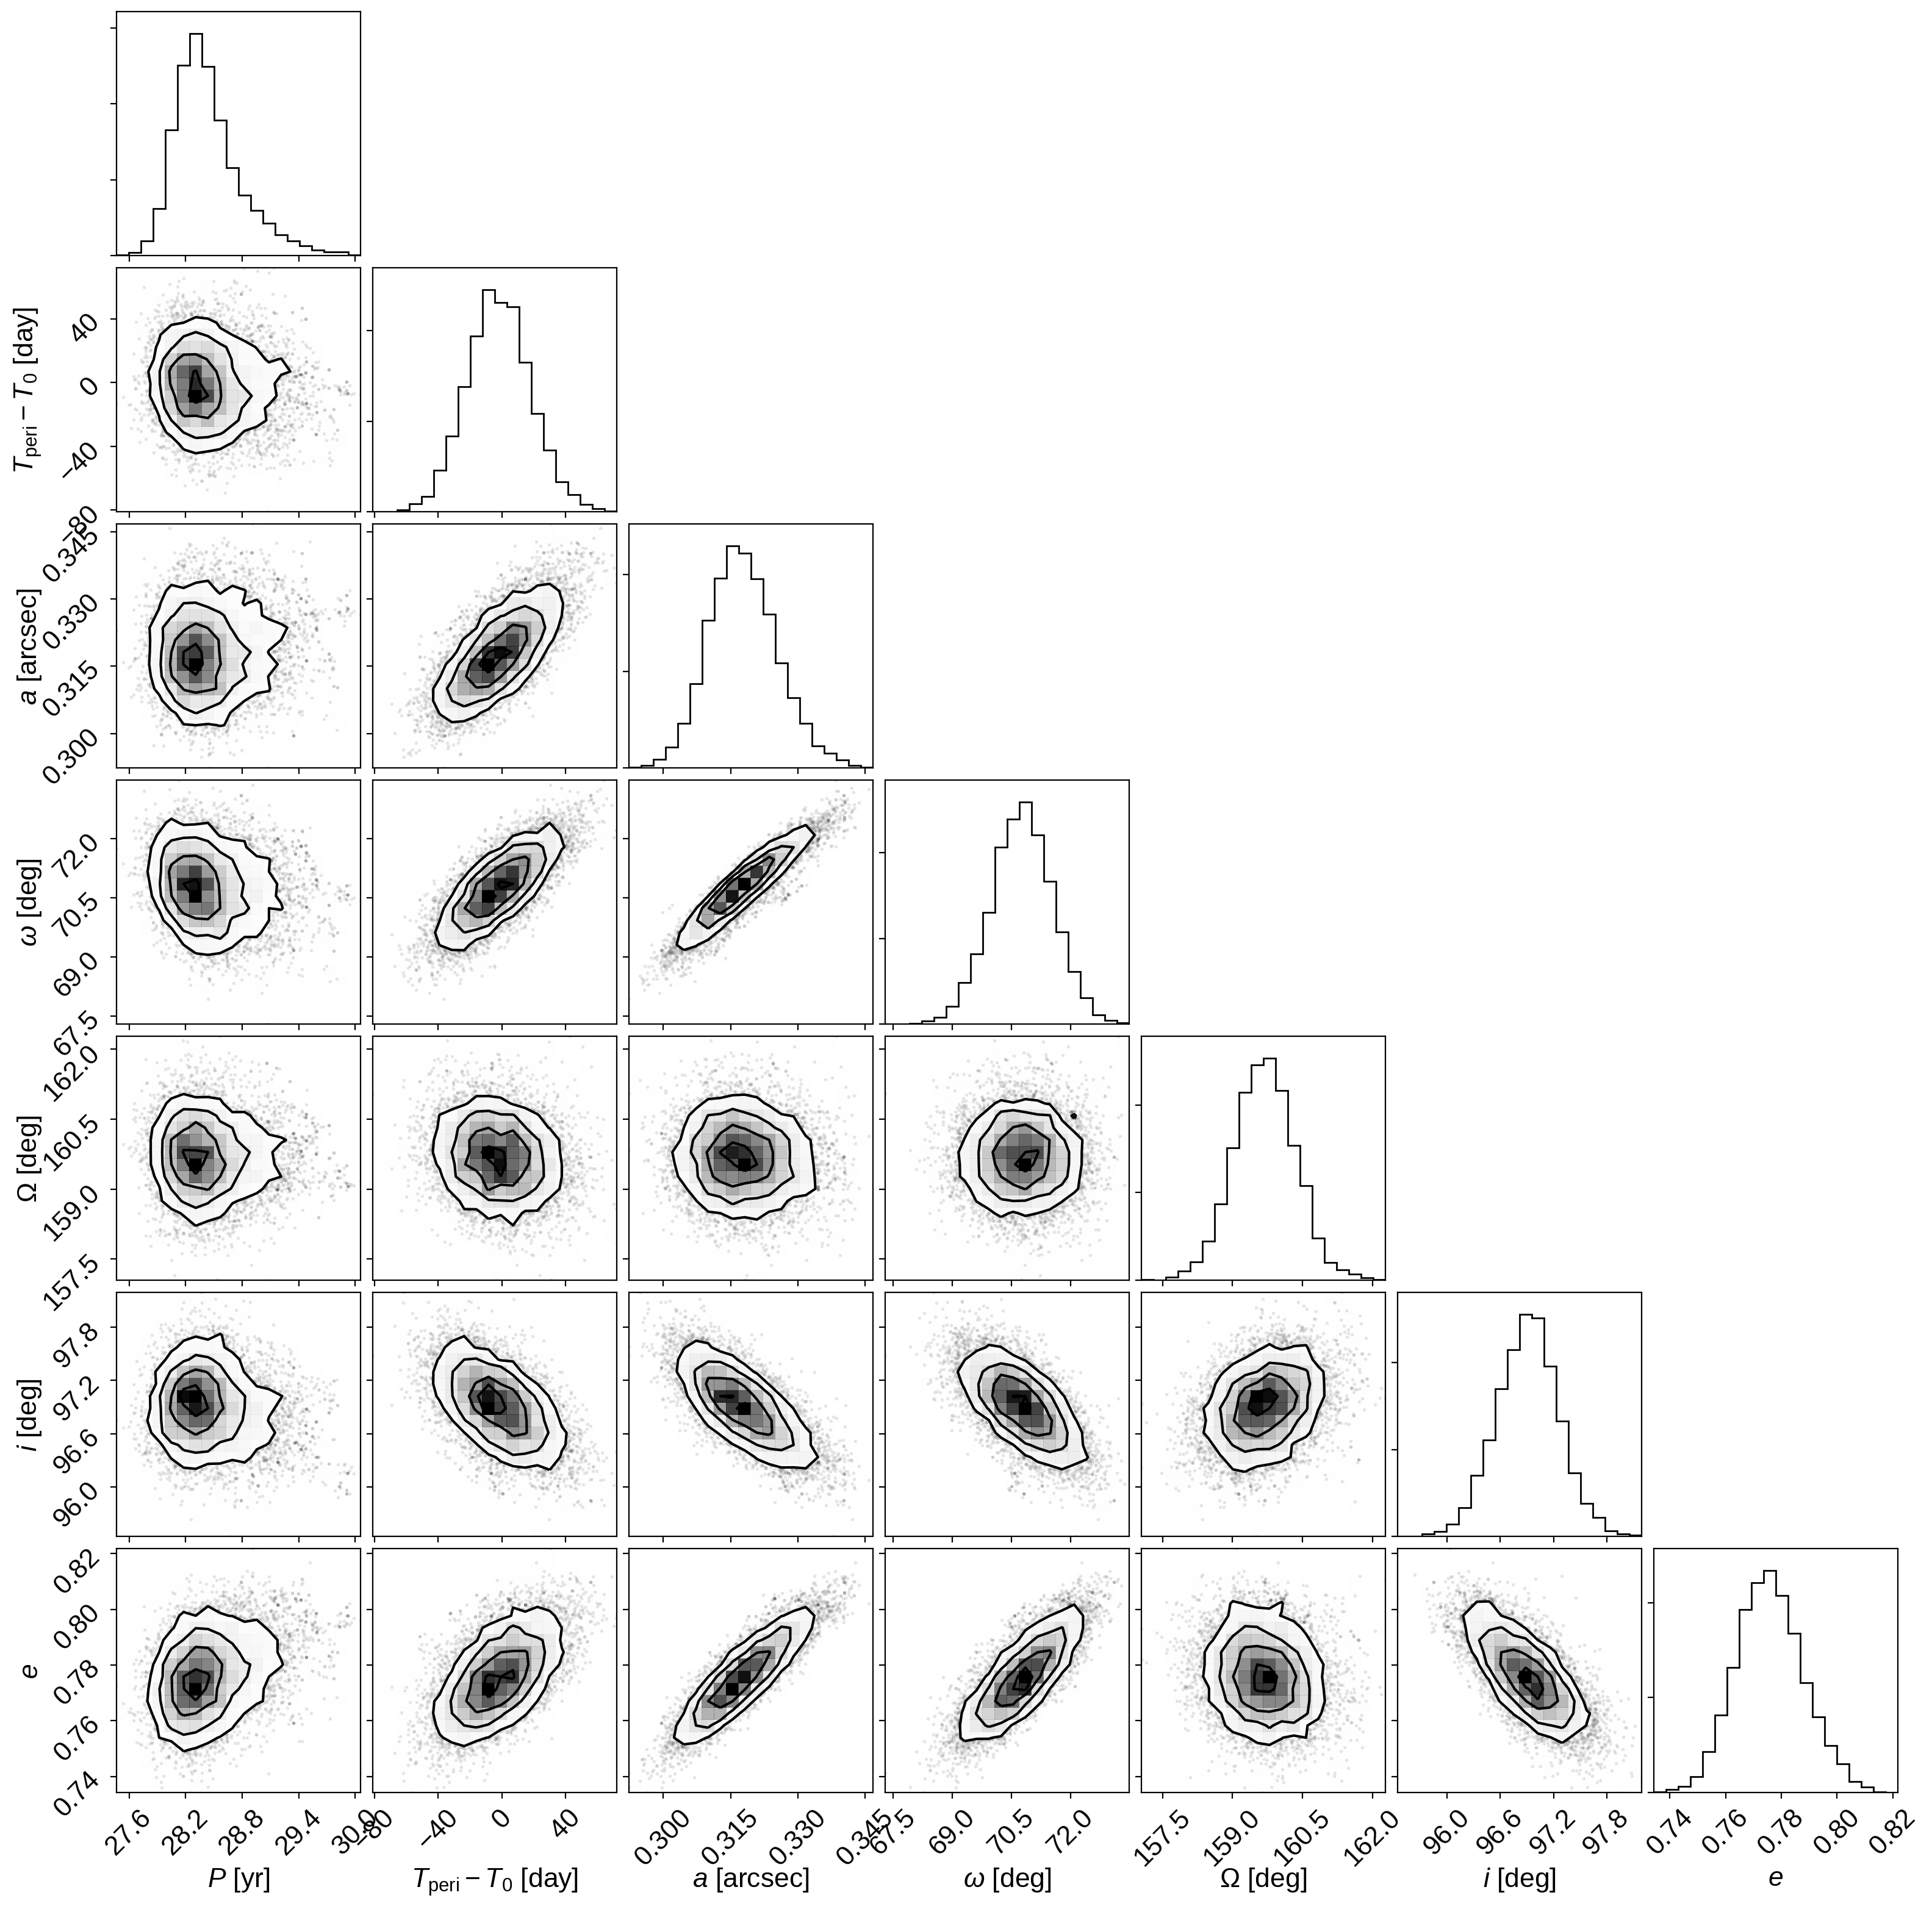

In [12]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["ecc"])
samples["$P$ [yr]"] = trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = trace["tperi"] - T0
samples["$a$ [arcsec]"] = trace["a_ang"]
samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
samples["$e$"] = samples["ecc"]
del samples["ecc"]
_ = corner.corner(samples)

Finally, we can plot the posterior constraints on $\rho$ and $\theta$.
This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

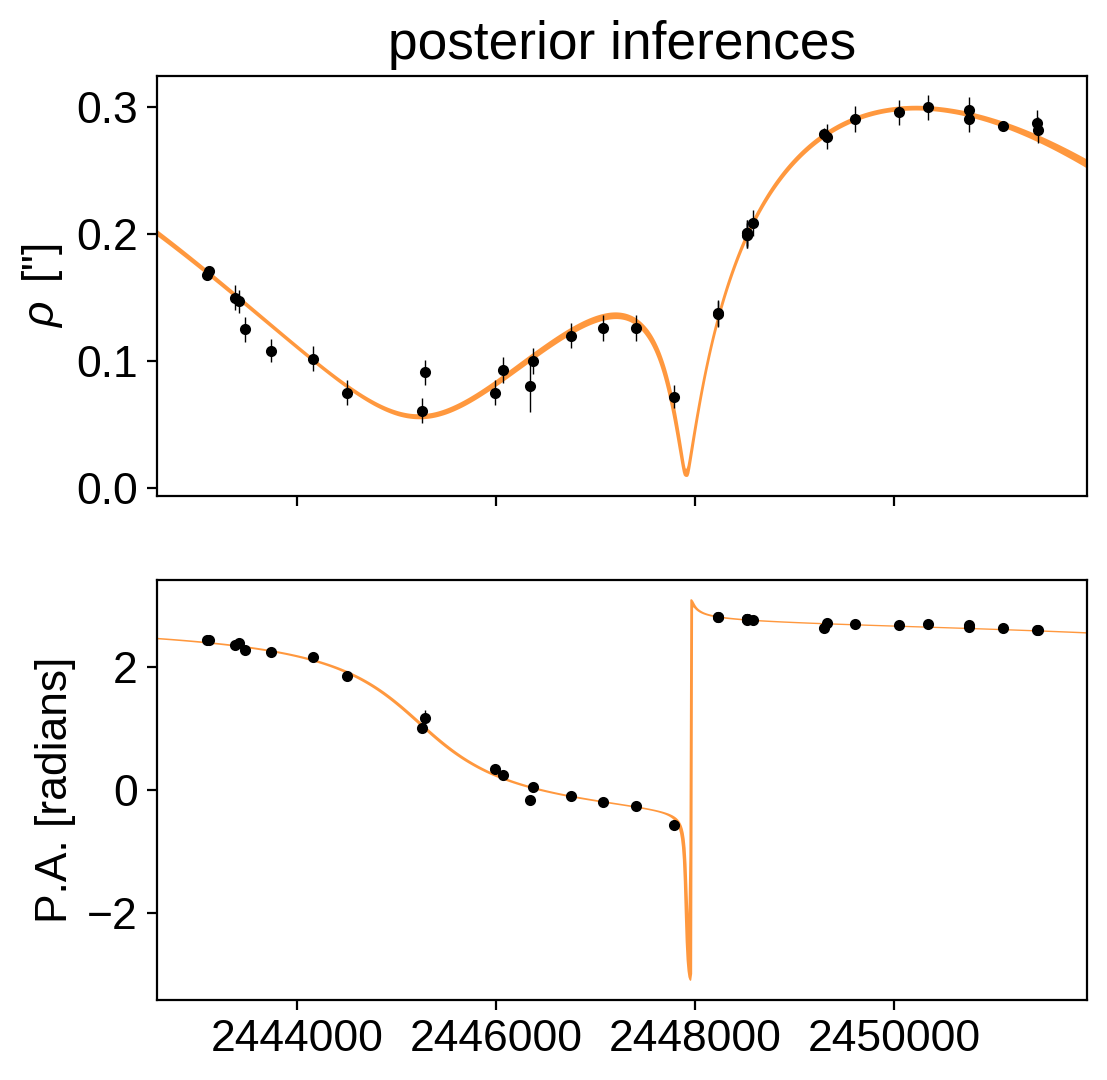

In [13]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"P.A. [radians]")

tot_rho_err = np.sqrt(
    rho_err ** 2 + np.exp(2 * np.median(trace["log_rho_s"], axis=0))
)
tot_theta_err = np.sqrt(
    theta_err ** 2 + np.exp(2 * np.median(trace["log_theta_s"], axis=0))
)

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace["rho_save"], [16, 84], axis=0)
ax[0].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace["theta_save"], [16, 84], axis=0)
ax[1].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("posterior inferences")

As we can see from the narrow range of orbits (the orange swath appears like a thin line), the orbit is actually highly constrained by the astrometry.
We also see two outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit.
It's likely the uncertainties were not estimated correctly for these, and the simlplistic jitter model we implemented isn't sophisticated to apply more weight to only these discrepant points.

## Including parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truely intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem.

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.

We can use exactly the same model as above with only an added parallax constraint:

In [14]:
plx_model, plx_map_soln = get_model(parallax=[24.05, 0.45])

optimizing logp for variables: [log_theta_s, log_rho_s]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.076402e+02]

1it [00:00, 498.73it/s, logp=1.076402e+02]

2it [00:00, 669.96it/s, logp=1.476711e+02]

3it [00:00, 736.79it/s, logp=1.084303e+02]

4it [00:00, 804.93it/s, logp=1.485840e+02]

5it [00:00, 842.03it/s, logp=1.497845e+02]

6it [00:00, 852.91it/s, logp=1.499280e+02]

7it [00:00, 862.14it/s, logp=1.499286e+02]

8it [00:00, 886.91it/s, logp=1.499286e+02]

9it [00:00, 909.21it/s, logp=1.499286e+02]

10it [00:00, 12.02it/s, logp=1.499286e+02]


message: Optimization terminated successfully.
logp: 107.64015029566296 -> 149.92860106267193


optimizing logp for variables: [phase]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.499286e+02]

1it [00:00, 493.97it/s, logp=1.499286e+02]

2it [00:00, 651.59it/s, logp=-1.185553e+04]

3it [00:00, 751.35it/s, logp=1.499517e+02] 

4it [00:00, 798.76it/s, logp=1.499982e+02]

5it [00:00, 854.69it/s, logp=1.501832e+02]

6it [00:00, 905.41it/s, logp=1.509035e+02]

7it [00:00, 931.06it/s, logp=1.535077e+02]

8it [00:00, 911.56it/s, logp=1.593811e+02]

9it [00:00, 927.72it/s, logp=1.662757e+02]

10it [00:00, 927.27it/s, logp=1.694242e+02]

11it [00:00, 944.82it/s, logp=1.703302e+02]

12it [00:00, 941.20it/s, logp=1.704061e+02]

13it [00:00, 956.80it/s, logp=1.704094e+02]

14it [00:00, 967.80it/s, logp=1.704128e+02]

15it [00:00, 944.75it/s, logp=1.704184e+02]

16it [00:00, 956.46it/s, logp=1.704249e+02]

17it [00:00, 962.94it/s, logp=1.704265e+02]

18it [00:00, 964.18it/s, logp=1.704268e+02]

19it [00:00, 970.87it/s, logp=1.704268e+02]

20it [00:00, 974.94it/s, logp=1.704268e+02]

21it [00:00, 970.20it/s, logp=1.704268e+02]

22it [00:00, 25.92it/s, logp=1.704268e+02] 


message: Optimization terminated successfully.
logp: 149.92860106267193 -> 170.4268151845905


optimizing logp for variables: [ecc, m, p]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.704268e+02]

1it [00:00, 636.08it/s, logp=1.704268e+02]

2it [00:00, 731.03it/s, logp=-4.518236e+03]

3it [00:00, 774.81it/s, logp=1.710200e+02] 

4it [00:00, 785.78it/s, logp=1.695336e+02]

5it [00:00, 840.81it/s, logp=1.711520e+02]

6it [00:00, 815.59it/s, logp=1.714066e+02]

7it [00:00, 853.84it/s, logp=1.721879e+02]

8it [00:00, 863.38it/s, logp=1.742150e+02]

9it [00:00, 888.18it/s, logp=1.812157e+02]

10it [00:00, 876.63it/s, logp=1.949820e+02]

11it [00:00, 887.87it/s, logp=1.964691e+02]

12it [00:00, 862.64it/s, logp=1.992100e+02]

13it [00:00, 870.41it/s, logp=2.038785e+02]

14it [00:00, 878.02it/s, logp=2.102587e+02]

15it [00:00, 882.40it/s, logp=2.122110e+02]

16it [00:00, 884.23it/s, logp=2.126408e+02]

17it [00:00, 879.18it/s, logp=2.126846e+02]

18it [00:00, 886.38it/s, logp=2.126998e+02]

19it [00:00, 891.19it/s, logp=2.127263e+02]

20it [00:00, 894.01it/s, logp=2.127699e+02]

21it [00:00, 898.40it/s, logp=2.128244e+02]

22it [00:00, 901.83it/s, logp=2.128398e+02]

23it [00:00, 869.00it/s, logp=2.128456e+02]

24it [00:00, 872.78it/s, logp=2.128460e+02]

25it [00:00, 876.74it/s, logp=2.128463e+02]

26it [00:00, 867.99it/s, logp=2.128468e+02]

27it [00:00, 871.69it/s, logp=2.128475e+02]

28it [00:00, 874.73it/s, logp=2.128479e+02]

29it [00:00, 878.91it/s, logp=2.128480e+02]

30it [00:00, 881.87it/s, logp=2.128480e+02]

31it [00:00, 883.19it/s, logp=2.128480e+02]

32it [00:00, 886.39it/s, logp=2.128480e+02]

33it [00:00, 889.81it/s, logp=2.128480e+02]

34it [00:00, 39.38it/s, logp=2.128480e+02] 


message: Optimization terminated successfully.
logp: 170.42681518459054 -> 212.8480158855976


optimizing logp for variables: [phase, a_ang, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.128480e+02]

1it [00:00, 639.77it/s, logp=2.128480e+02]

2it [00:00, 625.36it/s, logp=-4.375386e+03]

3it [00:00, 695.50it/s, logp=2.129960e+02] 

4it [00:00, 745.95it/s, logp=2.131453e+02]

5it [00:00, 787.31it/s, logp=2.132729e+02]

6it [00:00, 817.66it/s, logp=2.132857e+02]

7it [00:00, 810.34it/s, logp=2.132857e+02]

8it [00:00, 835.85it/s, logp=2.132860e+02]

9it [00:00, 841.91it/s, logp=2.132860e+02]

10it [00:00, 855.54it/s, logp=2.132860e+02]

11it [00:00, 13.15it/s, logp=2.132860e+02] 


message: Optimization terminated successfully.
logp: 212.8480158855976 -> 213.28597909410882


optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.132860e+02]

1it [00:00, 492.17it/s, logp=2.132860e+02]

2it [00:00, 531.87it/s, logp=-4.038433e+03]

3it [00:00, 599.39it/s, logp=2.152474e+02] 

4it [00:00, 649.45it/s, logp=1.676432e+02]

5it [00:00, 673.42it/s, logp=2.153207e+02]

6it [00:00, 690.33it/s, logp=2.154316e+02]

7it [00:00, 706.45it/s, logp=2.156115e+02]

8it [00:00, 723.81it/s, logp=2.158705e+02]

9it [00:00, 723.82it/s, logp=2.160160e+02]

10it [00:00, 738.28it/s, logp=2.158620e+02]

11it [00:00, 746.49it/s, logp=2.160652e+02]

12it [00:00, 749.32it/s, logp=2.160890e+02]

13it [00:00, 755.01it/s, logp=2.161353e+02]

14it [00:00, 770.82it/s, logp=2.162848e+02]

15it [00:00, 767.07it/s, logp=2.166196e+02]

16it [00:00, 759.58it/s, logp=2.171740e+02]

17it [00:00, 764.18it/s, logp=2.175761e+02]

18it [00:00, 761.99it/s, logp=2.174845e+02]

19it [00:00, 770.97it/s, logp=2.176565e+02]

20it [00:00, 776.77it/s, logp=2.177043e+02]

21it [00:00, 772.46it/s, logp=2.177335e+02]

22it [00:00, 777.84it/s, logp=2.177622e+02]

23it [00:00, 774.18it/s, logp=2.177547e+02]

24it [00:00, 781.08it/s, logp=2.177767e+02]

25it [00:00, 779.19it/s, logp=2.177873e+02]

26it [00:00, 782.95it/s, logp=2.177936e+02]

27it [00:00, 781.35it/s, logp=2.178014e+02]

28it [00:00, 773.18it/s, logp=2.178034e+02]

29it [00:00, 773.54it/s, logp=2.178054e+02]

30it [00:00, 773.21it/s, logp=2.178058e+02]

31it [00:00, 774.15it/s, logp=2.178059e+02]

32it [00:00, 774.00it/s, logp=2.178059e+02]

33it [00:00, 777.14it/s, logp=2.178059e+02]

34it [00:00, 779.45it/s, logp=2.178059e+02]

35it [00:00, 782.59it/s, logp=2.178059e+02]

36it [00:00, 785.32it/s, logp=2.178059e+02]

37it [00:00, 779.19it/s, logp=2.178059e+02]

38it [00:00, 779.88it/s, logp=2.178059e+02]

39it [00:00, 784.51it/s, logp=2.178059e+02]

40it [00:00, 787.90it/s, logp=2.178059e+02]

41it [00:00, 790.35it/s, logp=2.178059e+02]

42it [00:00, 785.30it/s, logp=2.178059e+02]

43it [00:00, 788.96it/s, logp=2.178059e+02]

44it [00:00, 789.86it/s, logp=2.178059e+02]

45it [00:00, 790.64it/s, logp=2.178059e+02]

46it [00:00, 794.06it/s, logp=2.178059e+02]

47it [00:00, 796.47it/s, logp=2.178059e+02]

48it [00:00, 799.69it/s, logp=2.178059e+02]

49it [00:00, 803.76it/s, logp=2.178059e+02]

50it [00:00, 806.55it/s, logp=2.178059e+02]

51it [00:00, 809.01it/s, logp=2.178059e+02]

52it [00:00, 810.45it/s, logp=2.178059e+02]

53it [00:00, 813.92it/s, logp=2.178059e+02]

54it [00:00, 816.44it/s, logp=2.178059e+02]

55it [00:00, 816.63it/s, logp=2.178059e+02]

56it [00:00, 820.12it/s, logp=2.178059e+02]

57it [00:00, 814.38it/s, logp=2.178059e+02]

58it [00:00, 817.79it/s, logp=2.178059e+02]

59it [00:00, 815.53it/s, logp=2.178059e+02]

60it [00:00, 815.81it/s, logp=2.178059e+02]

61it [00:00, 816.41it/s, logp=2.178059e+02]

62it [00:00, 817.65it/s, logp=2.178059e+02]

63it [00:00, 819.60it/s, logp=2.178059e+02]

64it [00:00, 822.53it/s, logp=2.178059e+02]

65it [00:00, 825.12it/s, logp=2.178059e+02]

66it [00:00, 827.81it/s, logp=2.178059e+02]

67it [00:00, 819.42it/s, logp=2.178059e+02]

68it [00:00, 821.05it/s, logp=2.178059e+02]

69it [00:00, 823.25it/s, logp=2.178059e+02]

70it [00:00, 823.32it/s, logp=2.178059e+02]

71it [00:00, 824.81it/s, logp=2.178059e+02]

72it [00:00, 823.10it/s, logp=2.178059e+02]

73it [00:00, 824.72it/s, logp=2.178059e+02]

74it [00:00, 827.48it/s, logp=2.178059e+02]

75it [00:00, 829.52it/s, logp=2.178059e+02]

76it [00:00, 831.87it/s, logp=2.178059e+02]

77it [00:00, 834.15it/s, logp=2.178059e+02]

78it [00:00, 836.26it/s, logp=2.178059e+02]

79it [00:00, 834.15it/s, logp=2.178059e+02]

80it [00:00, 836.15it/s, logp=2.178059e+02]

81it [00:00, 838.40it/s, logp=2.178059e+02]

82it [00:00, 839.38it/s, logp=2.178059e+02]

83it [00:00, 840.87it/s, logp=2.178059e+02]

84it [00:00, 840.45it/s, logp=2.178059e+02]

85it [00:00, 846.91it/s, logp=2.178059e+02]

85it [00:00, 846.91it/s, logp=2.178059e+02]

86it [00:00, 846.91it/s, logp=2.178059e+02]

87it [00:00, 846.91it/s, logp=2.178059e+02]

88it [00:00, 846.91it/s, logp=2.178059e+02]

89it [00:00, 846.91it/s, logp=2.178059e+02]

90it [00:00, 846.91it/s, logp=2.178059e+02]

91it [00:00, 846.91it/s, logp=2.178059e+02]

92it [00:00, 846.91it/s, logp=2.178059e+02]

93it [00:00, 846.91it/s, logp=2.178059e+02]

94it [00:00, 846.91it/s, logp=2.178059e+02]

95it [00:00, 846.91it/s, logp=2.178059e+02]

96it [00:00, 846.91it/s, logp=2.178059e+02]

97it [00:00, 846.91it/s, logp=2.178059e+02]

98it [00:00, 846.91it/s, logp=2.178059e+02]

99it [00:00, 846.91it/s, logp=2.178059e+02]

100it [00:00, 846.91it/s, logp=2.178059e+02]

101it [00:00, 846.91it/s, logp=2.178059e+02]

102it [00:00, 846.91it/s, logp=2.178059e+02]

103it [00:00, 846.91it/s, logp=2.178059e+02]

104it [00:00, 846.91it/s, logp=2.178059e+02]

105it [00:00, 846.91it/s, logp=2.178059e+02]

106it [00:00, 846.91it/s, logp=2.178059e+02]

107it [00:00, 846.91it/s, logp=2.178059e+02]

108it [00:00, 846.91it/s, logp=2.178059e+02]

109it [00:00, 846.91it/s, logp=2.178059e+02]

110it [00:00, 846.91it/s, logp=2.178059e+02]

111it [00:00, 846.91it/s, logp=2.178059e+02]

112it [00:00, 846.91it/s, logp=2.178059e+02]

113it [00:00, 846.91it/s, logp=2.178059e+02]

114it [00:00, 120.43it/s, logp=2.178059e+02]


message: Desired error not necessarily achieved due to precision loss.
logp: 213.28597909410882 -> 217.8058683350306


In [15]:
np.random.seed(5432)
with plx_model:
    plx_trace = pm.sample(
        tune=5000,
        draws=4000,
        start=plx_map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9, start=plx_map_soln),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 2 chains, 0 divergences:   0%|          | 0/18000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 7/18000 [00:00<05:22, 55.78draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 9/18000 [00:00<08:48, 34.03draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 11/18000 [00:00<11:22, 26.37draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 13/18000 [00:00<13:07, 22.83draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 15/18000 [00:00<14:12, 21.10draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 17/18000 [00:00<14:59, 19.98draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 19/18000 [00:00<15:27, 19.38draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 21/18000 [00:00<15:54, 18.84draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 23/18000 [00:01<16:44, 17.90draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 25/18000 [00:01<16:42, 17.93draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 27/18000 [00:01<16:44, 17.90draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 29/18000 [00:01<16:46, 17.86draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 32/18000 [00:01<15:09, 19.75draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 35/18000 [00:01<15:45, 19.01draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 37/18000 [00:01<16:39, 17.97draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 40/18000 [00:01<14:59, 19.97draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 43/18000 [00:02<15:08, 19.77draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 46/18000 [00:02<13:59, 21.39draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 49/18000 [00:02<14:08, 21.16draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 52/18000 [00:02<13:20, 22.43draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 56/18000 [00:02<12:21, 24.19draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 59/18000 [00:02<12:21, 24.21draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 62/18000 [00:02<12:27, 24.00draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 65/18000 [00:03<14:42, 20.32draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 68/18000 [00:03<14:10, 21.09draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 71/18000 [00:03<15:02, 19.86draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 74/18000 [00:03<14:52, 20.10draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 77/18000 [00:03<16:03, 18.61draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 79/18000 [00:03<16:09, 18.48draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 81/18000 [00:03<16:18, 18.31draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 84/18000 [00:04<15:59, 18.68draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 86/18000 [00:04<16:08, 18.49draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 88/18000 [00:04<16:38, 17.93draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 91/18000 [00:04<14:56, 19.97draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 94/18000 [00:04<14:40, 20.33draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 97/18000 [00:04<13:34, 21.98draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 100/18000 [00:04<15:51, 18.81draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 103/18000 [00:04<14:39, 20.34draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 106/18000 [00:05<14:01, 21.26draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 109/18000 [00:05<13:41, 21.78draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 112/18000 [00:05<13:18, 22.40draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 115/18000 [00:05<14:28, 20.60draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 119/18000 [00:05<13:42, 21.75draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 122/18000 [00:05<13:40, 21.80draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 125/18000 [00:05<13:09, 22.64draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 128/18000 [00:06<13:18, 22.37draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 131/18000 [00:06<14:26, 20.62draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 134/18000 [00:06<13:29, 22.08draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 137/18000 [00:06<13:43, 21.69draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 140/18000 [00:06<12:57, 22.96draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 143/18000 [00:06<12:51, 23.14draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 146/18000 [00:06<12:13, 24.34draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 150/18000 [00:07<12:13, 24.32draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 153/18000 [00:07<12:00, 24.78draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 156/18000 [00:07<12:26, 23.89draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 159/18000 [00:07<13:42, 21.69draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 164/18000 [00:07<12:56, 22.97draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 167/18000 [00:07<12:17, 24.19draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 170/18000 [00:07<12:16, 24.19draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 173/18000 [00:08<14:44, 20.16draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 176/18000 [00:08<14:23, 20.65draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 179/18000 [00:08<14:04, 21.09draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 182/18000 [00:08<13:07, 22.64draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 185/18000 [00:08<13:19, 22.28draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 188/18000 [00:08<12:34, 23.60draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 191/18000 [00:08<14:07, 21.02draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 194/18000 [00:08<13:50, 21.44draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 197/18000 [00:09<13:52, 21.39draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 200/18000 [00:09<15:58, 18.58draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 203/18000 [00:09<14:29, 20.48draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 206/18000 [00:09<15:30, 19.12draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 209/18000 [00:09<14:12, 20.88draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 212/18000 [00:09<14:53, 19.90draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 215/18000 [00:10<13:52, 21.37draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 221/18000 [00:10<11:23, 26.02draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 231/18000 [00:10<08:58, 33.02draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 245/18000 [00:10<06:57, 42.56draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 260/18000 [00:10<05:27, 54.16draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 279/18000 [00:10<04:17, 68.78draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 301/18000 [00:10<03:24, 86.50draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 323/18000 [00:10<02:47, 105.45draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 347/18000 [00:10<02:19, 126.45draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 367/18000 [00:10<02:04, 142.11draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 387/18000 [00:11<01:57, 150.42draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 411/18000 [00:11<01:45, 167.20draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 433/18000 [00:11<01:38, 178.98draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 456/18000 [00:11<01:32, 189.46draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 478/18000 [00:11<01:29, 196.04draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 501/18000 [00:11<01:25, 205.06draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 523/18000 [00:11<01:29, 194.70draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 544/18000 [00:11<01:35, 182.04draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 563/18000 [00:12<01:47, 161.98draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 581/18000 [00:12<01:52, 155.17draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 603/18000 [00:12<01:42, 169.63draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 625/18000 [00:12<01:36, 179.45draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 644/18000 [00:12<01:41, 170.29draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 665/18000 [00:12<01:37, 178.36draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 684/18000 [00:12<01:38, 175.41draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 705/18000 [00:12<01:35, 181.89draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 725/18000 [00:12<01:35, 180.51draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 744/18000 [00:13<01:36, 179.05draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 763/18000 [00:13<01:43, 166.26draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 780/18000 [00:13<01:43, 165.69draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 803/18000 [00:13<01:36, 178.13draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 822/18000 [00:13<01:36, 178.35draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 841/18000 [00:13<01:40, 171.12draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 862/18000 [00:13<01:35, 178.94draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 881/18000 [00:13<01:37, 174.77draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 899/18000 [00:13<01:43, 165.08draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 919/18000 [00:14<01:39, 171.69draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 940/18000 [00:14<01:37, 175.33draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 962/18000 [00:14<01:33, 183.13draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 981/18000 [00:14<01:32, 183.18draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1000/18000 [00:14<01:38, 173.21draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1021/18000 [00:14<01:35, 178.71draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1040/18000 [00:14<01:37, 173.79draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1058/18000 [00:14<01:38, 171.30draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1077/18000 [00:14<01:36, 174.69draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1095/18000 [00:15<01:38, 171.68draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1113/18000 [00:15<01:45, 160.81draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1130/18000 [00:15<01:43, 162.94draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1153/18000 [00:15<01:34, 178.43draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1172/18000 [00:15<01:33, 179.68draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1191/18000 [00:15<01:32, 181.42draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1214/18000 [00:15<01:27, 190.92draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1234/18000 [00:15<01:36, 174.48draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1252/18000 [00:15<01:35, 175.71draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1270/18000 [00:16<01:34, 176.38draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1288/18000 [00:16<01:39, 167.77draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1307/18000 [00:16<01:36, 172.46draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1325/18000 [00:16<01:42, 162.53draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1343/18000 [00:16<01:40, 166.04draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1363/18000 [00:16<01:36, 171.76draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1386/18000 [00:16<01:30, 184.48draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1407/18000 [00:16<01:27, 189.22draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1431/18000 [00:16<01:23, 198.58draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1452/18000 [00:17<01:27, 188.39draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1472/18000 [00:17<01:27, 189.51draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1494/18000 [00:17<01:24, 195.81draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1514/18000 [00:17<01:23, 196.53draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1534/18000 [00:17<01:28, 186.58draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1553/18000 [00:17<01:36, 170.10draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1571/18000 [00:17<01:44, 156.72draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1588/18000 [00:17<01:43, 159.30draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1610/18000 [00:17<01:35, 171.51draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1633/18000 [00:18<01:28, 184.91draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1656/18000 [00:18<01:23, 195.66draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1677/18000 [00:18<01:27, 185.88draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1697/18000 [00:18<01:27, 186.99draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1717/18000 [00:18<01:31, 177.81draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1737/18000 [00:18<01:29, 182.53draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1762/18000 [00:18<01:22, 196.30draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1783/18000 [00:18<01:22, 195.45draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1803/18000 [00:18<01:24, 192.44draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1823/18000 [00:19<01:25, 189.07draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1843/18000 [00:19<01:36, 166.99draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1861/18000 [00:19<01:40, 159.91draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1878/18000 [00:19<01:44, 153.95draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1897/18000 [00:19<01:39, 161.53draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1914/18000 [00:19<01:39, 162.13draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1935/18000 [00:19<01:32, 173.40draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1957/18000 [00:19<01:26, 185.02draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1978/18000 [00:19<01:23, 190.96draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1998/18000 [00:20<01:24, 189.77draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 2018/18000 [00:20<01:33, 170.70draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2036/18000 [00:20<01:35, 166.89draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2054/18000 [00:20<01:40, 158.86draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2071/18000 [00:20<01:43, 153.24draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2096/18000 [00:20<01:32, 172.58draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2117/18000 [00:20<01:28, 178.72draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2137/18000 [00:20<01:26, 183.38draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2157/18000 [00:20<01:24, 186.84draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2177/18000 [00:21<01:31, 173.01draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2196/18000 [00:21<01:29, 176.49draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2215/18000 [00:21<01:28, 177.39draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2233/18000 [00:21<01:29, 175.37draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2251/18000 [00:21<01:36, 163.98draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2268/18000 [00:21<01:36, 162.84draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2286/18000 [00:21<01:35, 164.83draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2303/18000 [00:21<01:37, 161.80draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2322/18000 [00:21<01:33, 168.53draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2343/18000 [00:22<01:27, 179.11draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2363/18000 [00:22<01:24, 184.02draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2383/18000 [00:22<01:23, 187.79draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2406/18000 [00:22<01:18, 197.57draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2427/18000 [00:22<01:22, 188.52draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2447/18000 [00:22<01:22, 189.31draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2468/18000 [00:22<01:20, 193.42draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2488/18000 [00:22<01:21, 190.21draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2508/18000 [00:22<01:25, 180.87draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2527/18000 [00:23<01:31, 168.76draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2545/18000 [00:23<01:29, 171.91draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2563/18000 [00:23<01:29, 171.98draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2581/18000 [00:23<01:36, 159.48draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2598/18000 [00:23<01:37, 158.25draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2615/18000 [00:23<01:41, 151.49draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2635/18000 [00:23<01:34, 161.82draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2654/18000 [00:23<01:31, 168.54draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2674/18000 [00:23<01:27, 176.10draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2694/18000 [00:24<01:24, 180.11draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2714/18000 [00:24<01:23, 183.94draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2733/18000 [00:24<01:25, 178.19draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2751/18000 [00:24<01:25, 178.09draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2769/18000 [00:24<01:25, 178.17draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2787/18000 [00:24<01:25, 178.65draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2805/18000 [00:24<01:27, 174.34draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2823/18000 [00:24<01:35, 159.53draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2842/18000 [00:24<01:30, 166.80draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2860/18000 [00:24<01:28, 170.21draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2878/18000 [00:25<01:28, 171.75draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2896/18000 [00:25<01:28, 171.21draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2918/18000 [00:25<01:23, 181.10draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2937/18000 [00:25<01:23, 181.19draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2956/18000 [00:25<01:23, 180.91draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2976/18000 [00:25<01:20, 185.56draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2995/18000 [00:25<01:26, 173.90draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3013/18000 [00:25<01:28, 168.45draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3031/18000 [00:25<01:29, 166.94draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3050/18000 [00:26<01:26, 173.12draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3068/18000 [00:26<01:25, 173.77draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3086/18000 [00:26<01:31, 163.79draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3103/18000 [00:26<01:40, 148.10draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3119/18000 [00:26<01:39, 150.17draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3141/18000 [00:26<01:30, 164.62draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3162/18000 [00:26<01:25, 174.27draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3181/18000 [00:26<01:27, 168.75draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3199/18000 [00:26<01:28, 167.94draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3217/18000 [00:27<01:26, 170.10draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3241/18000 [00:27<01:20, 184.35draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3264/18000 [00:27<01:15, 194.29draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3284/18000 [00:27<01:18, 187.88draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3304/18000 [00:27<01:18, 186.94draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3327/18000 [00:27<01:14, 197.49draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 3350/18000 [00:27<01:11, 205.20draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 3371/18000 [00:27<01:14, 196.56draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3391/18000 [00:27<01:15, 192.33draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3411/18000 [00:28<01:16, 191.72draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3432/18000 [00:28<01:14, 195.11draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3452/18000 [00:28<01:18, 184.74draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3476/18000 [00:28<01:14, 195.99draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3496/18000 [00:28<01:18, 185.34draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3515/18000 [00:28<01:26, 167.34draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3534/18000 [00:28<01:25, 169.97draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3552/18000 [00:28<01:27, 164.94draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3569/18000 [00:28<01:34, 152.42draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3585/18000 [00:29<01:37, 147.73draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3605/18000 [00:29<01:29, 160.14draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3626/18000 [00:29<01:23, 172.13draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3646/18000 [00:29<01:20, 178.46draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3665/18000 [00:29<01:22, 173.75draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3683/18000 [00:29<01:25, 168.16draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3702/18000 [00:29<01:22, 174.10draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3721/18000 [00:29<01:21, 175.34draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3739/18000 [00:29<01:27, 163.01draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3756/18000 [00:30<01:27, 163.22draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3780/18000 [00:30<01:18, 180.12draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3803/18000 [00:30<01:14, 191.74draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3827/18000 [00:30<01:10, 200.27draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3849/18000 [00:30<01:09, 202.22draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3873/18000 [00:30<01:06, 211.05draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3895/18000 [00:30<01:08, 207.04draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3916/18000 [00:30<01:08, 206.50draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3937/18000 [00:30<01:09, 201.58draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3958/18000 [00:31<01:17, 180.61draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3977/18000 [00:31<01:17, 181.09draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3996/18000 [00:31<01:16, 183.54draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4015/18000 [00:31<01:17, 181.43draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4034/18000 [00:31<01:16, 182.32draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4053/18000 [00:31<01:18, 178.47draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4072/18000 [00:31<01:17, 180.00draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4091/18000 [00:31<01:16, 180.64draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4110/18000 [00:31<01:16, 181.21draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4131/18000 [00:32<01:14, 186.94draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4150/18000 [00:32<01:14, 185.09draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4169/18000 [00:32<01:19, 173.93draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4187/18000 [00:32<01:25, 162.41draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4204/18000 [00:32<01:28, 155.03draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4220/18000 [00:32<01:28, 156.40draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4236/18000 [00:32<01:29, 153.16draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4255/18000 [00:32<01:24, 162.10draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4275/18000 [00:32<01:20, 170.25draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4295/18000 [00:33<01:19, 173.43draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4316/18000 [00:33<01:15, 182.20draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4335/18000 [00:33<01:15, 180.98draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4354/18000 [00:33<01:20, 169.24draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4372/18000 [00:33<01:19, 170.36draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4394/18000 [00:33<01:14, 181.65draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4413/18000 [00:33<01:18, 172.80draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4431/18000 [00:33<01:20, 167.90draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4449/18000 [00:33<01:20, 169.36draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4468/18000 [00:34<01:19, 171.26draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4486/18000 [00:34<01:18, 171.76draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4504/18000 [00:34<01:18, 171.88draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4525/18000 [00:34<01:14, 179.93draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4545/18000 [00:34<01:13, 183.85draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4564/18000 [00:34<01:13, 181.88draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4584/18000 [00:34<01:12, 186.20draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4603/18000 [00:34<01:13, 181.79draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4622/18000 [00:34<01:13, 181.19draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4643/18000 [00:34<01:10, 188.55draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4665/18000 [00:35<01:08, 195.29draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4685/18000 [00:35<01:07, 196.27draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4705/18000 [00:35<01:09, 191.27draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4725/18000 [00:35<01:11, 184.52draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4744/18000 [00:35<01:11, 184.58draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4763/18000 [00:35<01:13, 179.96draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4782/18000 [00:35<01:15, 174.16draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4800/18000 [00:35<01:17, 170.26draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4819/18000 [00:35<01:15, 173.68draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4839/18000 [00:36<01:12, 180.37draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4860/18000 [00:36<01:09, 187.79draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4882/18000 [00:36<01:07, 194.58draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4903/18000 [00:36<01:06, 197.66draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4923/18000 [00:36<01:07, 192.91draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4943/18000 [00:36<01:09, 187.24draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4962/18000 [00:36<01:09, 186.80draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4981/18000 [00:36<01:13, 178.26draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4999/18000 [00:36<01:15, 172.08draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5017/18000 [00:37<01:16, 170.26draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5036/18000 [00:37<01:14, 174.53draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5057/18000 [00:37<01:11, 180.90draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5076/18000 [00:37<01:16, 169.12draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5094/18000 [00:37<01:22, 156.55draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5111/18000 [00:37<01:24, 153.11draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5127/18000 [00:37<01:25, 151.03draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 5143/18000 [00:37<01:28, 144.47draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 5160/18000 [00:37<01:24, 151.28draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5180/18000 [00:38<01:20, 158.98draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5199/18000 [00:38<01:17, 165.30draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5217/18000 [00:38<01:15, 168.50draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5235/18000 [00:38<01:20, 158.34draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5252/18000 [00:38<01:25, 149.50draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5268/18000 [00:38<01:24, 149.98draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5287/18000 [00:38<01:20, 158.15draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5310/18000 [00:38<01:13, 172.83draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5329/18000 [00:38<01:11, 176.79draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5349/18000 [00:39<01:10, 180.72draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5373/18000 [00:39<01:04, 194.71draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5396/18000 [00:39<01:01, 203.35draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5417/18000 [00:39<01:09, 180.86draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5436/18000 [00:39<01:13, 171.91draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5455/18000 [00:39<01:12, 173.21draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5474/18000 [00:39<01:11, 176.29draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5492/18000 [00:39<01:10, 177.04draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5513/18000 [00:39<01:07, 185.33draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5535/18000 [00:40<01:05, 190.29draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5555/18000 [00:40<01:06, 187.24draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5574/18000 [00:40<01:10, 177.34draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5593/18000 [00:40<01:09, 179.52draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5612/18000 [00:40<01:13, 169.24draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5630/18000 [00:40<01:14, 166.85draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5647/18000 [00:40<01:15, 163.73draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5664/18000 [00:40<01:16, 161.16draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5684/18000 [00:40<01:12, 170.95draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5708/18000 [00:41<01:06, 184.23draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5727/18000 [00:41<01:06, 184.08draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5746/18000 [00:41<01:07, 181.32draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5765/18000 [00:41<01:07, 181.22draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5785/18000 [00:41<01:05, 186.34draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5804/18000 [00:41<01:06, 184.65draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5823/18000 [00:41<01:06, 182.03draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5843/18000 [00:41<01:05, 185.91draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5866/18000 [00:41<01:02, 194.20draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5887/18000 [00:41<01:01, 195.72draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5907/18000 [00:42<01:03, 191.20draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5927/18000 [00:42<01:06, 182.25draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5946/18000 [00:42<01:06, 181.55draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5968/18000 [00:42<01:03, 190.24draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5988/18000 [00:42<01:10, 170.81draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 6006/18000 [00:42<01:11, 168.64draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 6027/18000 [00:42<01:07, 177.22draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6049/18000 [00:42<01:03, 187.75draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6071/18000 [00:42<01:01, 194.30draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6094/18000 [00:43<00:58, 202.03draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6115/18000 [00:43<00:59, 198.67draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6136/18000 [00:43<01:07, 175.74draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6155/18000 [00:43<01:07, 176.28draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6176/18000 [00:43<01:04, 183.84draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6197/18000 [00:43<01:02, 188.12draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6217/18000 [00:43<01:01, 190.36draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6237/18000 [00:43<01:07, 175.40draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6255/18000 [00:43<01:10, 167.67draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6273/18000 [00:44<01:13, 158.48draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6291/18000 [00:44<01:11, 163.27draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6310/18000 [00:44<01:09, 168.65draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6329/18000 [00:44<01:08, 171.07draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6347/18000 [00:44<01:12, 160.55draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6364/18000 [00:44<01:11, 161.94draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6385/18000 [00:44<01:07, 172.20draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6410/18000 [00:44<01:01, 187.89draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6432/18000 [00:44<01:00, 192.77draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6452/18000 [00:45<01:02, 184.32draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6471/18000 [00:45<01:03, 182.63draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6490/18000 [00:45<01:04, 177.88draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6509/18000 [00:45<01:06, 173.24draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6527/18000 [00:45<01:11, 160.73draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6546/18000 [00:45<01:08, 166.45draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6563/18000 [00:45<01:11, 159.55draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6580/18000 [00:45<01:16, 150.10draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6596/18000 [00:46<01:15, 150.68draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6616/18000 [00:46<01:11, 160.25draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6638/18000 [00:46<01:06, 171.81draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6656/18000 [00:46<01:09, 164.01draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6673/18000 [00:46<01:12, 156.66draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6691/18000 [00:46<01:10, 161.09draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6715/18000 [00:46<01:03, 176.84draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6734/18000 [00:46<01:05, 172.75draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6752/18000 [00:46<01:08, 164.65draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6769/18000 [00:47<01:11, 157.23draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6786/18000 [00:47<01:09, 160.85draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6803/18000 [00:47<01:09, 161.40draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6823/18000 [00:47<01:05, 170.33draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6841/18000 [00:47<01:08, 162.51draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6858/18000 [00:47<01:09, 160.00draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6876/18000 [00:47<01:07, 164.74draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6899/18000 [00:47<01:01, 179.58draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6918/18000 [00:47<01:02, 177.96draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6937/18000 [00:47<01:01, 179.60draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6957/18000 [00:48<01:00, 182.14draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6976/18000 [00:48<01:00, 182.00draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6995/18000 [00:48<01:04, 169.71draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7014/18000 [00:48<01:05, 168.27draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7032/18000 [00:48<01:05, 166.58draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7052/18000 [00:48<01:02, 174.59draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7070/18000 [00:48<01:02, 175.27draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7088/18000 [00:48<01:07, 160.88draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7105/18000 [00:49<01:08, 159.27draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7124/18000 [00:49<01:05, 166.98draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7143/18000 [00:49<01:02, 173.07draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7161/18000 [00:49<01:07, 161.69draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7178/18000 [00:49<01:07, 160.96draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7195/18000 [00:49<01:07, 160.20draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7218/18000 [00:49<01:01, 175.49draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7241/18000 [00:49<00:57, 186.37draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7261/18000 [00:49<01:08, 157.06draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7278/18000 [00:50<01:07, 158.78draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7299/18000 [00:50<01:03, 168.88draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7320/18000 [00:50<00:59, 178.56draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7339/18000 [00:50<01:01, 172.15draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7357/18000 [00:50<01:06, 160.65draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7374/18000 [00:50<01:05, 161.26draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7391/18000 [00:50<01:05, 163.14draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7409/18000 [00:50<01:03, 167.47draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7429/18000 [00:50<01:00, 175.19draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7452/18000 [00:51<00:56, 185.80draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7471/18000 [00:51<00:59, 176.92draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7490/18000 [00:51<00:59, 176.25draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7513/18000 [00:51<00:55, 188.41draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7536/18000 [00:51<00:53, 196.37draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7557/18000 [00:51<00:53, 195.36draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7577/18000 [00:51<00:53, 195.91draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7597/18000 [00:51<00:58, 176.42draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7616/18000 [00:51<00:59, 173.11draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7635/18000 [00:52<00:58, 176.68draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7653/18000 [00:52<01:03, 163.28draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7671/18000 [00:52<01:01, 166.89draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7688/18000 [00:52<01:03, 163.29draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7705/18000 [00:52<01:03, 161.42draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7724/18000 [00:52<01:01, 167.63draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7745/18000 [00:52<00:57, 177.82draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7764/18000 [00:52<00:57, 178.88draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7783/18000 [00:52<00:56, 179.80draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7802/18000 [00:52<00:56, 180.46draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7821/18000 [00:53<00:58, 174.87draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7839/18000 [00:53<00:58, 174.43draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7857/18000 [00:53<01:02, 162.75draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7874/18000 [00:53<01:02, 160.91draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7891/18000 [00:53<01:03, 159.54draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7909/18000 [00:53<01:01, 163.75draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7928/18000 [00:53<01:00, 167.69draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7946/18000 [00:53<00:59, 168.04draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7963/18000 [00:53<01:01, 164.28draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7980/18000 [00:54<01:00, 164.61draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7999/18000 [00:54<00:58, 169.94draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8017/18000 [00:54<00:59, 166.95draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8039/18000 [00:54<00:56, 175.77draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8057/18000 [00:54<00:58, 169.89draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8075/18000 [00:54<01:03, 156.72draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8091/18000 [00:54<01:05, 151.98draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8107/18000 [00:54<01:04, 153.67draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8127/18000 [00:54<01:00, 164.20draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8148/18000 [00:55<00:56, 175.13draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8170/18000 [00:55<00:53, 183.42draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8190/18000 [00:55<00:53, 184.88draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8212/18000 [00:55<00:50, 193.25draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8237/18000 [00:55<00:47, 207.04draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8259/18000 [00:55<00:47, 204.72draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8283/18000 [00:55<00:45, 212.53draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8306/18000 [00:55<00:45, 214.81draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8330/18000 [00:55<00:44, 218.11draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8352/18000 [00:56<00:44, 217.36draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8374/18000 [00:56<00:47, 201.45draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8395/18000 [00:56<00:49, 193.51draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8415/18000 [00:56<00:49, 192.81draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8436/18000 [00:56<00:48, 196.11draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8457/18000 [00:56<00:47, 199.62draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8478/18000 [00:56<00:50, 189.65draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8498/18000 [00:56<00:53, 177.14draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8517/18000 [00:56<00:53, 177.90draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8536/18000 [00:57<00:52, 179.38draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8556/18000 [00:57<00:51, 183.63draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8575/18000 [00:57<00:54, 174.21draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8593/18000 [00:57<00:57, 164.15draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8610/18000 [00:57<00:56, 164.85draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8627/18000 [00:57<00:56, 165.36draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8644/18000 [00:57<00:57, 162.02draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8661/18000 [00:57<01:02, 150.56draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8677/18000 [00:57<01:02, 149.52draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8695/18000 [00:58<00:59, 156.98draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8711/18000 [00:58<01:01, 151.91draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8731/18000 [00:58<00:57, 162.20draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8748/18000 [00:58<00:57, 161.80draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8765/18000 [00:58<00:57, 162.00draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8784/18000 [00:58<00:55, 167.00draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8803/18000 [00:58<00:53, 172.26draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8824/18000 [00:58<00:51, 177.20draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8842/18000 [00:58<00:55, 164.92draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8859/18000 [00:59<00:58, 157.33draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8875/18000 [00:59<01:00, 151.35draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8897/18000 [00:59<00:55, 164.71draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8917/18000 [00:59<00:52, 172.42draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8937/18000 [00:59<00:51, 175.05draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8955/18000 [00:59<00:53, 169.92draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8973/18000 [00:59<00:56, 159.23draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8990/18000 [00:59<00:59, 151.01draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9006/18000 [00:59<01:01, 146.81draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9021/18000 [01:00<01:01, 146.74draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9036/18000 [01:00<01:02, 144.43draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9052/18000 [01:00<01:01, 145.70draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9067/18000 [01:00<01:01, 144.46draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9087/18000 [01:00<00:57, 154.96draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9104/18000 [01:00<00:56, 157.63draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9120/18000 [01:00<00:58, 151.57draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9138/18000 [01:00<00:56, 158.23draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9157/18000 [01:00<00:53, 165.28draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9176/18000 [01:01<00:51, 171.47draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9194/18000 [01:01<00:50, 173.08draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9212/18000 [01:01<00:53, 162.77draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9229/18000 [01:01<00:55, 158.64draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9246/18000 [01:01<00:56, 154.24draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9263/18000 [01:01<00:55, 157.88draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9279/18000 [01:01<00:56, 154.44draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9295/18000 [01:01<00:56, 154.17draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9313/18000 [01:01<00:54, 160.72draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9331/18000 [01:01<00:52, 165.33draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9350/18000 [01:02<00:50, 171.85draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9369/18000 [01:02<00:48, 176.17draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9387/18000 [01:02<00:53, 161.02draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9404/18000 [01:02<00:53, 160.66draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9421/18000 [01:02<00:54, 158.63draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9438/18000 [01:02<00:53, 159.81draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9456/18000 [01:02<00:52, 162.52draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9473/18000 [01:02<00:51, 164.15draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9495/18000 [01:02<00:48, 176.60draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9518/18000 [01:03<00:45, 188.41draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9538/18000 [01:03<00:44, 190.66draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9558/18000 [01:03<00:46, 182.65draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9577/18000 [01:03<00:45, 184.27draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9596/18000 [01:03<00:48, 172.73draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9614/18000 [01:03<00:48, 172.92draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9635/18000 [01:03<00:46, 180.63draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9654/18000 [01:03<00:47, 177.53draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9672/18000 [01:03<00:51, 163.22draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9689/18000 [01:04<00:52, 159.04draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9706/18000 [01:04<00:52, 157.33draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9725/18000 [01:04<00:50, 164.43draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9742/18000 [01:04<00:51, 161.08draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9759/18000 [01:04<00:50, 162.16draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9779/18000 [01:04<00:48, 170.77draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9798/18000 [01:04<00:47, 173.41draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9816/18000 [01:04<00:48, 167.87draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9833/18000 [01:04<00:48, 167.33draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9851/18000 [01:05<00:48, 167.80draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9871/18000 [01:05<00:46, 175.47draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9892/18000 [01:05<00:44, 183.68draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9911/18000 [01:05<00:45, 176.50draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9930/18000 [01:05<00:45, 178.43draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9948/18000 [01:05<00:45, 175.58draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9966/18000 [01:05<00:45, 175.05draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9984/18000 [01:05<00:45, 176.29draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10002/18000 [01:05<00:45, 174.86draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10021/18000 [01:05<00:44, 177.40draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10042/18000 [01:06<00:43, 184.36draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10061/18000 [01:06<00:42, 184.72draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10080/18000 [01:06<00:44, 178.46draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10100/18000 [01:06<00:42, 184.34draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10119/18000 [01:06<00:46, 168.07draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10137/18000 [01:06<00:48, 161.83draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10154/18000 [01:06<00:49, 158.96draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10171/18000 [01:06<00:50, 156.26draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10188/18000 [01:06<00:48, 160.02draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10205/18000 [01:07<00:49, 156.74draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10223/18000 [01:07<00:48, 161.79draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10240/18000 [01:07<00:47, 163.47draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10259/18000 [01:07<00:45, 168.64draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10276/18000 [01:07<00:46, 167.10draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10294/18000 [01:07<00:45, 169.42draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10312/18000 [01:07<00:45, 169.35draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10331/18000 [01:07<00:44, 171.25draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▊    | 10350/18000 [01:07<00:43, 175.38draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10368/18000 [01:08<00:43, 174.81draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10387/18000 [01:08<00:42, 178.17draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10405/18000 [01:08<00:42, 177.92draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10423/18000 [01:08<00:44, 172.05draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10441/18000 [01:08<00:44, 169.01draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10458/18000 [01:08<00:45, 164.30draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10475/18000 [01:08<00:46, 162.84draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10495/18000 [01:08<00:43, 172.39draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10513/18000 [01:08<00:43, 170.42draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10531/18000 [01:08<00:44, 169.05draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10549/18000 [01:09<00:46, 159.61draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10568/18000 [01:09<00:44, 167.58draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10587/18000 [01:09<00:42, 173.67draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10605/18000 [01:09<00:43, 168.34draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10623/18000 [01:09<00:44, 166.33draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10641/18000 [01:09<00:43, 168.73draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10658/18000 [01:09<00:43, 168.69draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10675/18000 [01:09<00:44, 165.27draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10694/18000 [01:09<00:42, 171.73draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10712/18000 [01:10<00:42, 173.34draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10730/18000 [01:10<00:42, 170.54draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10748/18000 [01:10<00:42, 171.49draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10766/18000 [01:10<00:43, 167.66draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10783/18000 [01:10<00:42, 168.07draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10803/18000 [01:10<00:41, 174.23draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10821/18000 [01:10<00:40, 175.16draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10839/18000 [01:10<00:41, 173.93draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10857/18000 [01:10<00:41, 172.45draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10875/18000 [01:11<00:42, 166.46draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10892/18000 [01:11<00:42, 167.36draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10911/18000 [01:11<00:40, 173.12draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10929/18000 [01:11<00:40, 172.58draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10947/18000 [01:11<00:40, 173.57draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10965/18000 [01:11<00:40, 174.78draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10983/18000 [01:11<00:40, 173.69draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 11001/18000 [01:11<00:40, 174.26draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 11019/18000 [01:11<00:40, 174.43draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11039/18000 [01:11<00:38, 178.80draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11057/18000 [01:12<00:41, 169.14draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11075/18000 [01:12<00:41, 168.28draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11093/18000 [01:12<00:40, 168.85draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11111/18000 [01:12<00:40, 170.77draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11130/18000 [01:12<00:39, 175.54draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11148/18000 [01:12<00:40, 168.45draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11165/18000 [01:12<00:41, 164.64draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11182/18000 [01:12<00:42, 159.53draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11200/18000 [01:12<00:41, 162.33draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11217/18000 [01:13<00:42, 161.36draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11234/18000 [01:13<00:42, 160.30draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11251/18000 [01:13<00:41, 162.79draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11268/18000 [01:13<00:41, 162.08draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11285/18000 [01:13<00:41, 161.14draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11302/18000 [01:13<00:41, 160.11draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11319/18000 [01:13<00:41, 162.32draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11337/18000 [01:13<00:39, 166.91draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11354/18000 [01:13<00:40, 164.76draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11371/18000 [01:13<00:42, 154.78draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11389/18000 [01:14<00:41, 158.45draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11407/18000 [01:14<00:40, 163.44draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11424/18000 [01:14<00:40, 162.99draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 11441/18000 [01:14<00:40, 162.18draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 11458/18000 [01:14<00:40, 162.07draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11475/18000 [01:14<00:39, 163.89draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11492/18000 [01:14<00:40, 162.15draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11511/18000 [01:14<00:39, 165.43draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11528/18000 [01:14<00:39, 165.62draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11545/18000 [01:15<00:39, 162.96draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11564/18000 [01:15<00:38, 167.58draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11583/18000 [01:15<00:37, 169.54draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11600/18000 [01:15<00:38, 166.26draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11619/18000 [01:15<00:37, 170.00draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11637/18000 [01:15<00:37, 168.58draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11654/18000 [01:15<00:39, 160.65draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11673/18000 [01:15<00:37, 166.67draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11690/18000 [01:15<00:37, 166.32draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11708/18000 [01:16<00:37, 167.03draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11725/18000 [01:16<00:37, 165.84draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11744/18000 [01:16<00:36, 172.02draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11762/18000 [01:16<00:36, 171.20draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11780/18000 [01:16<00:36, 168.55draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11797/18000 [01:16<00:36, 168.54draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11818/18000 [01:16<00:34, 178.48draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11837/18000 [01:16<00:35, 174.46draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11855/18000 [01:16<00:36, 168.82draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11874/18000 [01:16<00:35, 172.68draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11892/18000 [01:17<00:36, 167.64draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11909/18000 [01:17<00:36, 165.56draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11927/18000 [01:17<00:36, 168.17draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11948/18000 [01:17<00:34, 176.15draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11966/18000 [01:17<00:35, 170.89draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 11984/18000 [01:17<00:36, 164.60draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12002/18000 [01:17<00:35, 166.99draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12020/18000 [01:17<00:35, 167.43draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12039/18000 [01:17<00:34, 170.42draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12057/18000 [01:18<00:34, 173.15draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12075/18000 [01:18<00:34, 169.42draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12093/18000 [01:18<00:34, 170.69draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12111/18000 [01:18<00:35, 164.92draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12128/18000 [01:18<00:35, 165.02draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12145/18000 [01:18<00:35, 165.46draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12162/18000 [01:18<00:35, 163.16draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12180/18000 [01:18<00:35, 165.01draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12198/18000 [01:18<00:34, 168.81draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12216/18000 [01:18<00:33, 171.48draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12235/18000 [01:19<00:33, 173.63draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12253/18000 [01:19<00:33, 173.68draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12271/18000 [01:19<00:32, 174.65draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12289/18000 [01:19<00:32, 173.08draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12307/18000 [01:19<00:32, 173.89draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12325/18000 [01:19<00:32, 175.40draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 12344/18000 [01:19<00:31, 177.69draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 12362/18000 [01:19<00:32, 173.25draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12380/18000 [01:19<00:32, 170.31draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12398/18000 [01:20<00:34, 163.98draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12415/18000 [01:20<00:33, 164.98draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12432/18000 [01:20<00:33, 164.88draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12449/18000 [01:20<00:33, 165.66draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12467/18000 [01:20<00:32, 168.87draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12487/18000 [01:20<00:31, 176.49draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12505/18000 [01:20<00:32, 167.75draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12523/18000 [01:20<00:32, 167.67draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12540/18000 [01:20<00:33, 164.36draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12557/18000 [01:21<00:33, 163.74draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12574/18000 [01:21<00:32, 165.45draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12591/18000 [01:21<00:33, 163.25draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12609/18000 [01:21<00:32, 167.66draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12626/18000 [01:21<00:31, 168.07draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12643/18000 [01:21<00:31, 168.26draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12660/18000 [01:21<00:32, 162.69draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12678/18000 [01:21<00:32, 165.19draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12696/18000 [01:21<00:31, 168.58draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12714/18000 [01:21<00:31, 169.04draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12731/18000 [01:22<00:31, 167.09draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12751/18000 [01:22<00:30, 174.48draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12769/18000 [01:22<00:30, 171.18draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12787/18000 [01:22<00:30, 169.46draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12805/18000 [01:22<00:30, 171.55draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12823/18000 [01:22<00:31, 166.44draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 12841/18000 [01:22<00:30, 169.08draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 12858/18000 [01:22<00:31, 161.15draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12875/18000 [01:22<00:31, 162.45draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12892/18000 [01:23<00:31, 161.93draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12909/18000 [01:23<00:31, 159.70draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12926/18000 [01:23<00:31, 160.55draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12943/18000 [01:23<00:30, 163.26draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12962/18000 [01:23<00:29, 170.29draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12982/18000 [01:23<00:28, 176.36draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13000/18000 [01:23<00:31, 157.50draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13017/18000 [01:23<00:32, 154.35draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13035/18000 [01:23<00:31, 159.92draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13052/18000 [01:24<00:31, 157.26draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13068/18000 [01:24<00:35, 140.49draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13083/18000 [01:24<00:35, 138.06draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13098/18000 [01:24<00:35, 139.55draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13113/18000 [01:24<00:37, 130.25draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13127/18000 [01:24<00:38, 127.05draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13140/18000 [01:24<00:39, 122.04draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13153/18000 [01:24<00:39, 123.32draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13166/18000 [01:24<00:39, 123.09draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13179/18000 [01:25<00:40, 119.69draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13193/18000 [01:25<00:39, 123.24draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13211/18000 [01:25<00:35, 134.86draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13226/18000 [01:25<00:34, 138.29draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 13243/18000 [01:25<00:32, 145.23draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 13260/18000 [01:25<00:31, 150.72draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13277/18000 [01:25<00:30, 154.99draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13294/18000 [01:25<00:29, 157.61draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13311/18000 [01:25<00:30, 155.77draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13327/18000 [01:25<00:29, 156.84draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13347/18000 [01:26<00:28, 165.30draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13366/18000 [01:26<00:26, 171.74draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13386/18000 [01:26<00:26, 175.98draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13404/18000 [01:26<00:26, 175.57draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13422/18000 [01:26<00:26, 174.88draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13440/18000 [01:26<00:26, 169.60draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13458/18000 [01:26<00:27, 164.90draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13476/18000 [01:26<00:27, 166.51draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13494/18000 [01:26<00:26, 168.84draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13513/18000 [01:27<00:26, 172.24draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13532/18000 [01:27<00:25, 175.10draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13550/18000 [01:27<00:25, 174.72draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13568/18000 [01:27<00:26, 166.72draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13586/18000 [01:27<00:26, 167.77draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13603/18000 [01:27<00:26, 167.97draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13620/18000 [01:27<00:26, 165.31draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13637/18000 [01:27<00:27, 158.59draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13654/18000 [01:27<00:26, 160.98draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13671/18000 [01:28<00:26, 162.99draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13689/18000 [01:28<00:25, 167.17draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13707/18000 [01:28<00:25, 167.49draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13725/18000 [01:28<00:25, 168.24draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13742/18000 [01:28<00:26, 160.91draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13759/18000 [01:28<00:26, 162.15draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13776/18000 [01:28<00:26, 160.86draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13793/18000 [01:28<00:25, 162.49draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13810/18000 [01:28<00:27, 154.62draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13826/18000 [01:28<00:27, 152.82draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13845/18000 [01:29<00:26, 159.71draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13863/18000 [01:29<00:25, 164.30draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13880/18000 [01:29<00:25, 158.73draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13897/18000 [01:29<00:25, 161.26draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13914/18000 [01:29<00:24, 163.75draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13932/18000 [01:29<00:24, 165.06draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13950/18000 [01:29<00:24, 164.94draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13967/18000 [01:29<00:25, 160.80draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13984/18000 [01:29<00:25, 158.85draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14002/18000 [01:30<00:24, 163.92draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14019/18000 [01:30<00:24, 163.57draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14036/18000 [01:30<00:24, 164.13draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14054/18000 [01:30<00:23, 167.16draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14071/18000 [01:30<00:24, 163.32draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14088/18000 [01:30<00:23, 164.80draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14108/18000 [01:30<00:22, 172.02draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14126/18000 [01:30<00:22, 171.04draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14145/18000 [01:30<00:22, 174.01draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14168/18000 [01:30<00:20, 186.22draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14187/18000 [01:31<00:21, 179.97draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14206/18000 [01:31<00:22, 170.21draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14224/18000 [01:31<00:22, 167.26draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14241/18000 [01:31<00:23, 160.95draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14261/18000 [01:31<00:22, 169.20draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14279/18000 [01:31<00:22, 167.85draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14296/18000 [01:31<00:22, 167.77draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14313/18000 [01:31<00:22, 166.35draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14332/18000 [01:31<00:21, 171.54draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14350/18000 [01:32<00:21, 171.08draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14368/18000 [01:32<00:21, 167.11draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14388/18000 [01:32<00:20, 174.76draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14406/18000 [01:32<00:20, 175.69draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14424/18000 [01:32<00:20, 174.27draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14442/18000 [01:32<00:21, 168.82draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14459/18000 [01:32<00:21, 168.58draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14476/18000 [01:32<00:21, 164.99draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14493/18000 [01:32<00:21, 166.22draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14510/18000 [01:33<00:20, 166.62draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14529/18000 [01:33<00:20, 166.89draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14547/18000 [01:33<00:20, 170.35draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14565/18000 [01:33<00:20, 169.28draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14583/18000 [01:33<00:20, 168.03draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14604/18000 [01:33<00:19, 175.83draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14623/18000 [01:33<00:19, 176.41draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 14641/18000 [01:33<00:19, 169.74draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 14659/18000 [01:33<00:19, 168.31draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14676/18000 [01:34<00:20, 165.73draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14694/18000 [01:34<00:19, 166.93draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14711/18000 [01:34<00:19, 167.36draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14728/18000 [01:34<00:19, 164.51draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14745/18000 [01:34<00:19, 164.39draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14764/18000 [01:34<00:19, 170.18draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14784/18000 [01:34<00:18, 177.48draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14804/18000 [01:34<00:17, 180.32draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14824/18000 [01:34<00:17, 182.19draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14843/18000 [01:34<00:18, 175.35draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14862/18000 [01:35<00:17, 174.78draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14880/18000 [01:35<00:18, 169.79draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14898/18000 [01:35<00:18, 168.95draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14915/18000 [01:35<00:18, 165.02draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14933/18000 [01:35<00:18, 168.07draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14952/18000 [01:35<00:17, 172.83draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14970/18000 [01:35<00:17, 168.94draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14989/18000 [01:35<00:17, 173.53draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 15007/18000 [01:35<00:17, 173.09draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 15025/18000 [01:36<00:17, 172.91draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15043/18000 [01:36<00:17, 169.92draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15061/18000 [01:36<00:17, 171.36draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15079/18000 [01:36<00:17, 167.63draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15096/18000 [01:36<00:18, 157.54draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15114/18000 [01:36<00:17, 160.99draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15132/18000 [01:36<00:17, 164.69draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15149/18000 [01:36<00:17, 160.56draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15167/18000 [01:36<00:17, 163.08draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15184/18000 [01:37<00:17, 161.18draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15201/18000 [01:37<00:17, 157.35draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15217/18000 [01:37<00:17, 157.03draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15236/18000 [01:37<00:16, 164.95draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15255/18000 [01:37<00:16, 166.80draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15273/18000 [01:37<00:16, 168.18draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15290/18000 [01:37<00:16, 168.70draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15308/18000 [01:37<00:15, 171.34draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15327/18000 [01:37<00:15, 171.11draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15346/18000 [01:37<00:15, 173.75draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15364/18000 [01:38<00:15, 174.01draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15382/18000 [01:38<00:15, 174.23draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15400/18000 [01:38<00:15, 167.59draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15422/18000 [01:38<00:14, 179.30draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15441/18000 [01:38<00:14, 177.87draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15459/18000 [01:38<00:14, 176.37draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15477/18000 [01:38<00:14, 171.37draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15495/18000 [01:38<00:15, 162.25draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15512/18000 [01:38<00:16, 154.20draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15528/18000 [01:39<00:15, 155.15draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15547/18000 [01:39<00:15, 162.38draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15567/18000 [01:39<00:14, 169.90draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15585/18000 [01:39<00:15, 160.39draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15603/18000 [01:39<00:14, 164.52draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15620/18000 [01:39<00:14, 164.50draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15638/18000 [01:39<00:14, 166.04draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15655/18000 [01:39<00:14, 163.03draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15672/18000 [01:39<00:14, 164.35draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15689/18000 [01:40<00:14, 164.23draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15707/18000 [01:40<00:13, 167.01draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15726/18000 [01:40<00:13, 170.68draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15744/18000 [01:40<00:13, 165.93draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15762/18000 [01:40<00:13, 167.80draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15779/18000 [01:40<00:13, 162.53draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15796/18000 [01:40<00:13, 161.14draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15816/18000 [01:40<00:12, 168.73draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15836/18000 [01:40<00:12, 176.81draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15854/18000 [01:41<00:12, 169.92draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15872/18000 [01:41<00:12, 172.17draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15890/18000 [01:41<00:12, 168.32draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15907/18000 [01:41<00:12, 167.71draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15924/18000 [01:41<00:12, 167.60draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 15941/18000 [01:41<00:12, 159.76draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 15961/18000 [01:41<00:12, 167.39draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 15978/18000 [01:41<00:12, 168.05draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 15995/18000 [01:41<00:12, 163.73draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16012/18000 [01:41<00:12, 158.58draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16028/18000 [01:42<00:12, 151.81draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16044/18000 [01:42<00:13, 147.23draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16062/18000 [01:42<00:12, 153.88draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16078/18000 [01:42<00:12, 155.30draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16094/18000 [01:42<00:12, 152.37draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16110/18000 [01:42<00:12, 152.15draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16127/18000 [01:42<00:11, 156.96draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16146/18000 [01:42<00:11, 163.10draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16164/18000 [01:42<00:11, 162.09draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16181/18000 [01:43<00:11, 161.96draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16199/18000 [01:43<00:10, 166.98draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16216/18000 [01:43<00:11, 161.38draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16236/18000 [01:43<00:10, 171.03draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16254/18000 [01:43<00:10, 170.18draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16272/18000 [01:43<00:10, 167.07draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16289/18000 [01:43<00:10, 165.69draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16307/18000 [01:43<00:10, 166.47draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16325/18000 [01:43<00:09, 169.63draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16344/18000 [01:44<00:09, 171.79draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16363/18000 [01:44<00:09, 171.80draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16381/18000 [01:44<00:09, 171.48draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16400/18000 [01:44<00:09, 173.14draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16418/18000 [01:44<00:09, 165.22draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 16436/18000 [01:44<00:09, 166.83draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 16453/18000 [01:44<00:09, 162.25draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16471/18000 [01:44<00:09, 165.54draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16489/18000 [01:44<00:09, 164.37draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16507/18000 [01:44<00:08, 168.51draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16524/18000 [01:45<00:09, 163.66draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16541/18000 [01:45<00:09, 160.99draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16559/18000 [01:45<00:08, 164.06draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16578/18000 [01:45<00:08, 169.61draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16596/18000 [01:45<00:08, 168.81draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16614/18000 [01:45<00:08, 168.54draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16631/18000 [01:45<00:08, 163.99draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16649/18000 [01:45<00:08, 162.83draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16666/18000 [01:45<00:08, 164.74draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16683/18000 [01:46<00:08, 163.46draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16700/18000 [01:46<00:08, 161.71draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16720/18000 [01:46<00:07, 169.47draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16738/18000 [01:46<00:07, 166.25draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16755/18000 [01:46<00:07, 166.42draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16774/18000 [01:46<00:07, 168.34draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16791/18000 [01:46<00:07, 167.88draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16808/18000 [01:46<00:07, 166.29draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16828/18000 [01:46<00:06, 175.02draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16846/18000 [01:47<00:06, 167.65draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16863/18000 [01:47<00:06, 167.58draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16880/18000 [01:47<00:06, 166.25draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16897/18000 [01:47<00:06, 160.55draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16916/18000 [01:47<00:06, 166.53draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16934/18000 [01:47<00:06, 170.32draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16952/18000 [01:47<00:06, 169.06draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16969/18000 [01:47<00:06, 167.67draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16990/18000 [01:47<00:05, 173.56draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 17008/18000 [01:47<00:05, 171.64draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17027/18000 [01:48<00:05, 173.85draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17045/18000 [01:48<00:05, 167.24draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17063/18000 [01:48<00:05, 165.72draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17082/18000 [01:48<00:05, 169.19draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17099/18000 [01:48<00:05, 164.86draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17116/18000 [01:48<00:05, 161.75draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17134/18000 [01:48<00:05, 166.62draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17151/18000 [01:48<00:05, 163.36draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17168/18000 [01:48<00:05, 163.27draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17190/18000 [01:49<00:04, 176.33draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17208/18000 [01:49<00:04, 176.74draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17226/18000 [01:49<00:04, 168.78draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17244/18000 [01:49<00:04, 171.26draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17262/18000 [01:49<00:04, 166.12draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17281/18000 [01:49<00:04, 172.43draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17299/18000 [01:49<00:04, 170.23draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17317/18000 [01:49<00:04, 163.68draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17334/18000 [01:49<00:04, 156.79draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17354/18000 [01:50<00:03, 165.36draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17371/18000 [01:50<00:03, 164.58draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17389/18000 [01:50<00:03, 165.80draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17407/18000 [01:50<00:03, 168.87draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17425/18000 [01:50<00:03, 170.66draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17443/18000 [01:50<00:03, 172.00draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17461/18000 [01:50<00:03, 166.25draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17479/18000 [01:50<00:03, 166.67draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17496/18000 [01:50<00:03, 163.91draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17502/18000 [01:50<00:03, 163.91draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17514/18000 [01:50<00:02, 163.74draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17531/18000 [01:51<00:02, 161.33draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17548/18000 [01:51<00:02, 152.74draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17564/18000 [01:51<00:02, 151.41draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17580/18000 [01:51<00:02, 151.40draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17597/18000 [01:51<00:02, 152.98draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17613/18000 [01:51<00:02, 152.03draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17631/18000 [01:51<00:02, 156.82draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17647/18000 [01:51<00:02, 155.80draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17663/18000 [01:51<00:02, 150.66draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17683/18000 [01:52<00:02, 157.68draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17699/18000 [01:52<00:02, 132.39draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17714/18000 [01:52<00:02, 118.23draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17727/18000 [01:52<00:02, 110.61draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 17739/18000 [01:52<00:02, 106.49draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 17751/18000 [01:52<00:02, 101.69draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 17762/18000 [01:52<00:02, 96.67draws/s] 

Sampling 2 chains, 1 divergences:  99%|█████████▊| 17773/18000 [01:53<00:02, 93.51draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17783/18000 [01:53<00:02, 92.13draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17793/18000 [01:53<00:02, 91.67draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17803/18000 [01:53<00:02, 86.59draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17814/18000 [01:53<00:02, 89.58draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17825/18000 [01:53<00:01, 93.25draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17836/18000 [01:53<00:01, 94.10draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17847/18000 [01:53<00:01, 95.82draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17857/18000 [01:53<00:01, 93.82draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17867/18000 [01:54<00:01, 93.85draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17879/18000 [01:54<00:01, 98.61draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17889/18000 [01:54<00:01, 98.01draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17899/18000 [01:54<00:01, 96.11draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17909/18000 [01:54<00:00, 95.35draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17919/18000 [01:54<00:00, 95.22draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17929/18000 [01:54<00:00, 88.93draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17938/18000 [01:54<00:00, 83.63draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17949/18000 [01:54<00:00, 88.62draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17960/18000 [01:55<00:00, 92.47draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17970/18000 [01:55<00:00, 93.07draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17981/18000 [01:55<00:00, 94.73draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17991/18000 [01:55<00:00, 92.34draws/s]

Sampling 2 chains, 1 divergences: 100%|██████████| 18000/18000 [01:55<00:00, 155.80draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


Check the convergence diagnostics.

In [16]:
pm.summary(
    plx_trace,
    varnames=[
        "P",
        "tperi",
        "a_ang",
        "omega",
        "Omega",
        "incl",
        "ecc",
        "M_tot",
        "plx",
    ],
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,10382.211,124.983,10181.746,10634.112,2.754,1.959,2060.0,2036.0,2823.0,1902.0,1.0
tperi,2447861.433,20.266,2447820.850,2447897.161,0.292,0.206,4821.0,4821.0,4816.0,4684.0,1.0
a_ang,0.318,0.008,0.303,0.332,0.000,0.000,3503.0,3445.0,3766.0,3698.0,1.0
omega,1.235,0.014,1.209,1.261,0.000,0.000,3833.0,3825.0,3830.0,3678.0,1.0
Omega,2.787,0.012,2.764,2.809,0.000,0.000,5565.0,5560.0,5583.0,4818.0,1.0
incl,1.691,0.006,1.680,1.703,0.000,0.000,4462.0,4462.0,4491.0,3813.0,1.0
ecc,0.776,0.012,0.753,0.799,0.000,0.000,3070.0,3026.0,3383.0,3349.0,1.0
M_tot,2.868,0.273,2.366,3.382,0.004,0.003,5371.0,5337.0,5401.0,4984.0,1.0
plx,0.024,0.000,0.023,0.025,0.000,0.000,7095.0,7095.0,7093.0,5285.0,1.0


And make the corner plot for the physical parameters.

Substituting with a symbol from Computer Modern.


Substituting with a symbol from Computer Modern.


Substituting with a symbol from Computer Modern.


Substituting with a symbol from Computer Modern.


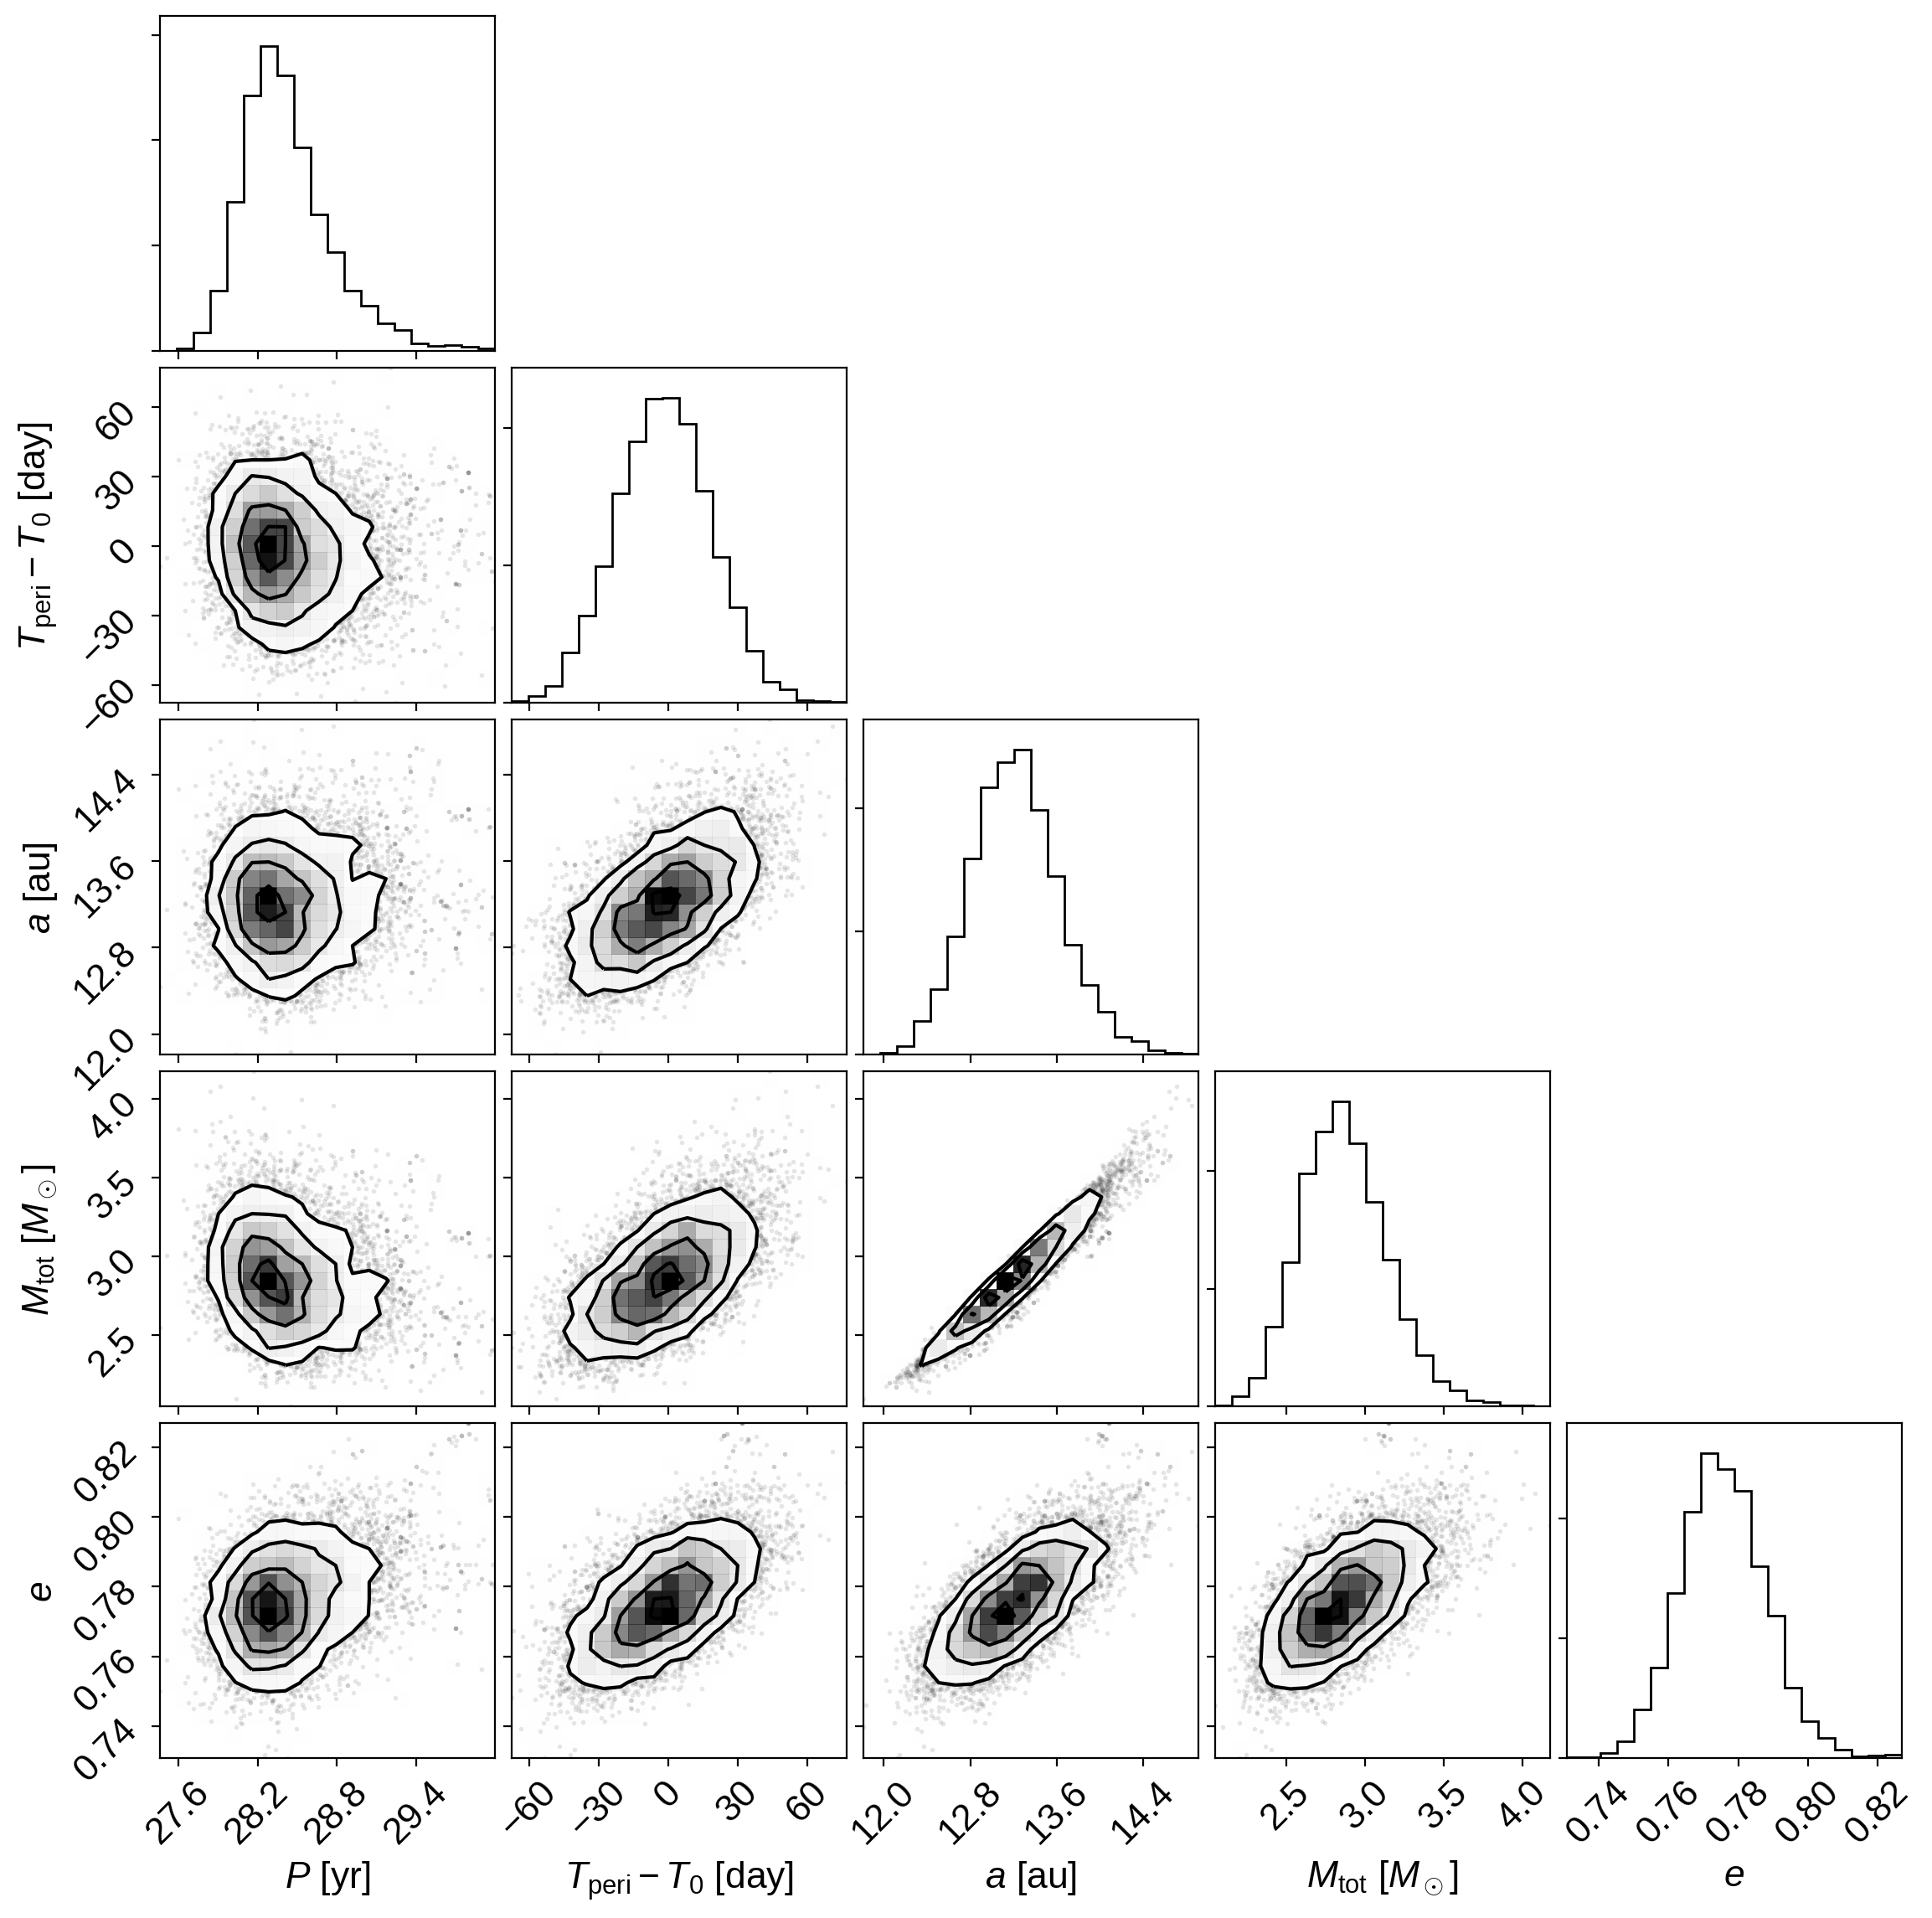

In [17]:
samples = pm.trace_to_dataframe(plx_trace, varnames=["ecc"])
samples["$P$ [yr]"] = plx_trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = plx_trace["tperi"] - T0
samples["$a$ [au]"] = plx_trace["a"]
samples["$M_\mathrm{tot}$ [$M_\odot$]"] = plx_trace["M_tot"]
samples["$e$"] = plx_trace["ecc"]
del samples["ecc"]
_ = corner.corner(samples)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [18]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [19]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.2.5},
   month = mar,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
